In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors
import math as mt
from collections import Counter
from scipy.stats import entropy, chi2_contingency, chisquare

import scipy.stats as stats
%matplotlib inline

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
from numpy import std, mean, sqrt
from scipy.special import rel_entr
from scipy.stats import wasserstein_distance

In [61]:
def make_stochastic_matrix(df):  #Transform a square matrix such that each row sums up to 1

    new_df = np.array(df.copy())
    for i in range(0, len(new_df)):
        row_sum = 0
        for j in range(0, len(new_df[0])):
            if new_df[i][j] == np.inf or pd.isna(new_df[i][j]):
                pass
            else:
                row_sum += new_df[i][j]
        if row_sum != 0:
            new_df[i] = new_df[i] / row_sum

    return pd.DataFrame(new_df)

In [62]:
def get_occurrence_freqs(df,
                            col_name,
                            note_list,
                            win_size,
                            symmetric=False):
    '''
    col_name is the name of the column that contains all the sequences
    note_list is a list that contains the possible values that a note in your sequence can take
    win_size is the window size, which is the maximum distance between two notes that you are looking for
    n is the number of Monte Carlo runs that should be conducted
    '''

    occurrence_vec = np.zeros(len(note_list))
    co_occurrence_matrix = np.zeros((len(note_list), len(note_list)))

    notes = np.array(note_list)
    note_indices = list(np.arange(0, len(note_list), 1))

    for i in range(0, df.shape[0]):  #For each sequence in the dataset
        
        sequence = list(df[col_name][i])

        #for run in range(0, n):  #For each Monte-Carlo run

            #Pick a random index from a uniform(0,len(sequence)-win_size) distribution
            #rand_index = np.random.randint(0, max(len(sequence) - win_size, 1))

            #Generate a random sample using this index value
            #sample = sequence[rand_index:rand_index + win_size]
        
        for note in range(len(sequence)):
            

            if win_size > len(sequence) - 1:
                sample = sequence

            else:
                sample = sequence[note:min(note+win_size,len(sequence))]
                if not len(sample):
                    break

            for i in range(len(sample)):

                note = sample[i]  #For each individual note in the sample

                #Find out which note it is
                try:
                    noteID = int(note_indices[np.where(note == notes)[0][0]])
                except IndexError:
                    continue  #If the note is not in the note_list provided, skip it

                #Add to the occurrence vector
                occurrence_vec[noteID] += 1

                for j in range(0, len(sample)):  #Look at all the other notes in the sample

                    othernote = sample[j]
                    try:
                        othernoteID = int(
                            note_indices[np.where(othernote == notes)[0][0]])

                    except IndexError:
                        continue  #If the note is not in the note_list provided, skip it

                    if symmetric:

                        if noteID == othernoteID and i != j:  #To avoid counting the same note twice, ensure indices are not equal

                            co_occurrence_matrix[noteID][othernoteID] += 1

                        elif noteID != othernoteID:

                            co_occurrence_matrix[noteID][othernoteID] += 1

                    else:

                        if i < j:  #This breaks the symmetry: Only count if note occurred before othernote

                            co_occurrence_matrix[noteID][othernoteID] += 1
                    
                    if win_size > (len(sequence) - 1):
                        break

    for i in range(0, len(note_list)):
        for j in range(0, len(note_list)):
            if occurrence_vec[i] * occurrence_vec[j] != 0:
                co_occurrence_matrix[i][j] = (co_occurrence_matrix[i][j]) / (
                    occurrence_vec[i] * occurrence_vec[j])

    marginal_probs = occurrence_vec / np.sum(
        occurrence_vec)  #Probability of occurrence

    co_occurrence_matrix = make_stochastic_matrix(
        pd.DataFrame(co_occurrence_matrix))

    return co_occurrence_matrix, marginal_probs

In [63]:
def make_new_sequences(df,
                       col_name,
                       notes,
                       marginal_probs):
    #Make a dataframe of random sequences given occurrence probabilities
    '''
    df is a dataframe of sequences
    col_name is the name of the column in df that contains all the sequences
    notes is a list or array that contains the possible values that a note in your sequence can take
    marginal_probs is a list that provides the stationary occurrence probability (frequency) of each note in note_list
    '''

    notes = np.array(notes)
    note_indices = list(np.arange(0, len(notes), 1))
    newdata = []

    cdf_cuts = np.zeros(len(marginal_probs) + 1)
    cdf = 0
    for i in range(1, len(marginal_probs) + 1):
        cdf += marginal_probs[i - 1]
        cdf_cuts[i] = cdf

    cdf_cuts[len(marginal_probs)] = 1

    for index in range(0, df.shape[0]):
        new_seq = ''
        seq_len = len(list(df[col_name][index]))

        for element in range(0, seq_len):
            rd = np.random.uniform()  #Pick a random float between 0 and 1

            for j in range(0,len(cdf_cuts)-1):  #Simulate a stationary distribution

                if cdf_cuts[j] <= rd and rd <= cdf_cuts[j + 1]:
                    note_index = note_indices[j]
                    note = notes[np.where(note_indices == note_index)[0][0]]

            new_seq += str(note)

        newdata.append(new_seq)

    newdata = pd.DataFrame(newdata)
    newdata = newdata.rename(mapper={0: col_name}, axis='columns')

    return newdata

In [64]:
def check_for_co_occurrence(df,
                            col_name,
                            note_list,
                            win_size,
                            #n=10000,
                            runs=100,
                            symmetric=False):

    original_co_occur, marginal_probs = get_occurrence_freqs(
        df, col_name, note_list, win_size, symmetric)

    exp_co_occur = np.zeros((len(note_list), len(note_list)))

    for run in range(runs):
        newdata = make_new_sequences(df, col_name, note_list, marginal_probs)
        new_co_occur = np.array(
            get_occurrence_freqs(newdata, col_name, note_list, win_size, symmetric)[0])

        for i in range(len(note_list)):
            for j in range(len(note_list)):
                exp_co_occur[i][j] += new_co_occur[i][j] / runs

    return original_co_occur, exp_co_occur

In [65]:
def normalized_deviation(obs, exp, max_allowed=5):
    '''
    obs is the dataframe of observed co-occurrences
    exp is the dataframe of expected co-occurrences
    '''

    ratio = np.array(obs / exp)

    #Make all values lie in the open interval [0,max_allowed]
    for i in range(len(ratio)):
        for j in range(len(ratio)):
            if ratio[i][j] > max_allowed:
                ratio[i][j] = max_allowed

            #Prevent small deviations around values like 0/0 from skewing the results
            if abs(obs[i][j] - 0) <= 10**-10 and abs(exp[i][j] - 0) <= 10**-10:
                ratio[i][j] = 1

    return pd.DataFrame(ratio)

In [66]:
def make_heatmap(df,
                 lab,
                 title='',
                 save=False,
                 file='heatmap',
                 cmap='icefire',
                 max_allowed=5):

    import math
    from matplotlib.colors import LogNorm

    fig, ax = plt.subplots(figsize=(12, 7))
    title = title
    plt.title(title, fontsize=18)
    
    #Scale is set to be in the interval [0,max_allowed], centered at 1
    hmap = sns.heatmap(df,
                       xticklabels=lab,
                       yticklabels=lab,
                       cmap=cmap,
                       norm=colors.TwoSlopeNorm(vmin=0,
                                                vcenter=1,
                                                vmax=max_allowed))
    hmap.figure.axes[-1].set_ylabel('observed:expected ratio', size=22)
    

    if save:
        plt.savefig(
            (file + ".svg"),
            dpi=500)  #Save the file as an SVG with a resolution of 500 dpi

    plt.show()

In [67]:
def get_vocab(data,col_name='note sequence'):
    
    vocab = set()
    for i in range(data.shape[0]):
            seq = list(data['note sequence'][i])
            for note in seq:
                vocab.add(note)
    
    return sorted(list(vocab))

In [68]:
def leven(a, b):
    # we must add an additional character at the start of each string
    a = f' {a}'
    b = f' {b}'
    # initialize empty zero array
    lev = np.zeros((len(a), len(b)))
    # now begin iterating through each value, finding the best path
    for i in range(len(a)):
        for j in range(len(b)):
            if min([i, j]) == 0:
                lev[i, j] = max([i, j])
            else:
                # calculate our three possible operations
                x = lev[i-1, j]  # deletion
                y = lev[i, j-1]  # insertion
                z = lev[i-1, j-1]  # substitution
                # take the minimum (eg best path/operation)
                lev[i, j] = min([x, y, z])
                # and if our two current characters don't match, add 1
                if a[i] != b[j]:
                    # if we have a match, don't add 1
                    lev[i, j] += 1
    return lev[-1, -1]

In [69]:
def shannon_entropy(df, base=None):
    note_seq=df['note sequence']
    H=np.zeros(len(note_seq))
    for i in range(len(note_seq)):
        value, counts=np.unique(list(note_seq[i]), return_counts=True)
        H[i]=entropy(counts)
    return np.transpose(H)
        

In [70]:
def freq_rep(df, col_name='note sequence'):
    notelist=get_vocab(df)
    seq_list=df[col_name]
    seq=seq_list[0]
    replist=list()
    df1=pd.DataFrame()
    df_out=pd.DataFrame()
    for note in notelist:
        noterep=0
        replist=list()
        for seq in seq_list:
            seq=seq+'x'
            for element in seq:
                if element == note:
                    noterep += 1
                elif (element != note):
                    replist.append(noterep)
                    noterep=0
        replist=[i for i in replist if i!=0]
        df1=pd.DataFrame({note:replist})
        df_out=pd.concat([df_out,df1],axis=1)
    return df_out

In [71]:
def ind_rep(df, col_name='note sequence'):
    notelist=get_vocab(df)
    seq_list=df[col_name]
    seq=seq_list[0]
    replist=list()
    df1=pd.DataFrame()
    df_out=pd.DataFrame()
    for seq in seq_list:
        seq=seq+'x'
        replist=list()
        noterep=0
        for element in seq:
            if element=='d':
                noterep+=1
                
            elif (element!= 'd'):
                replist.append(noterep)
                noterep=0
            
        replist=[i for i in replist if i!=0]
        #replist=[i for i in replist if i!=1]
        #print(replist)
        freq=pd.Series(sorted(replist))
        
        freq_ind=freq.value_counts().sort_index(0)
        #print(freq_ind)
        #prop_ind=pd.DataFrame(freq_ind/sum(freq_ind))
        #print(prop_ind)
        df1=pd.DataFrame(freq_ind).T
        #print(df1)
        df_out=pd.concat([df_out, df1])
        #print(df_out)
    #df_out=df_out.fillna(0)
    return df_out
        

In [72]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return abs((mean(x) - mean(y))) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

In [73]:
def random_cohen(df, col_name='note sequence', cage='Cage'):
    seq=df[col_name]
    cohen_dist=pd.DataFrame()
    print(seq)
    df_col=df.groupby(df[cage])
    
    df_col1=df_col.get_group(1)
    df_col2=df_col.get_group(2)
    df_col1=df_col1.reset_index()
    df_col2=df_col2.reset_index()
    
    rf_1=freq_rep(df_col1)
    rf_2=freq_rep(df_col2)
    
    r1d=pd.Series(sorted(rf_1['d']))
    f1d=r1d.value_counts().sort_index(0)
    
    r2d=pd.Series(sorted(rf_2['d']))
    f2d=r2d.value_counts().sort_index(0)
    
    prop_og1d=pd.DataFrame(f1d/sum(f1d))
    prop_og2d=pd.DataFrame(f2d/sum(f2d))
    
    cohen_og=cohen_d(prop_og1d,prop_og2d)
    
    for i in range(0,10000):
        seq_rand=np.random.permutation(seq)
        df[col_name]=seq_rand
        print(df[col_name])
        df_cage=df.groupby(df[cage])
        df_1=df_cage.get_group(1)
        df_2=df_cage.get_group(2)
        df_1=df_1.reset_index()
        df_2=df_2.reset_index()
        #print(df_1)
        rep_freq1=freq_rep(df_1)
        rep_freq2=freq_rep(df_2)
        
        rep1d=pd.Series(sorted(rep_freq1['d']))
        freq1d=rep1d.value_counts().sort_index(0)
        
        rep2d=pd.Series(sorted(rep_freq2['d']))
        freq2d=rep2d.value_counts().sort_index(0)
        
        prop1d=pd.DataFrame(freq1d/sum(freq1d))
        prop2d=pd.DataFrame(freq2d/sum(freq2d))
        
        cohen_di=cohen_d(prop1d, prop2d)
        #print(cohen_di)
        cohen_dist[i]=cohen_di
        #print(cohen_dist)
    cohen_dist=pd.DataFrame(cohen_dist).T
    avg_cohen=np.mean(cohen_dist)
    std_cohen=np.std(cohen_dist)
    return cohen_dist, cohen_og, avg_cohen, std_cohen
    

In [253]:
def repeat_vis(df, col_name='note sequence'):
    notelist=get_vocab(df)
    seq_list=df[col_name]
    seq=seq_list[0]
    new_seq=list()
    rep_seq=pd.DataFrame()
    
    for seq in seq_list:
        seq_new= seq.replace('d',"1").replace("a","0").replace("b","0").replace("c","0").replace("e","0").replace("f","0").replace("m","0").replace("0","0")
        seq_new=list(seq_new)
        new_seq.append(seq_new)
    
    #new_seq=pd.DataFrame(new_seq)
    #new_seq=pd.to_numeric(new_seq)
    return new_seq

In [180]:
dat_colony2

,index,Pair No,Date,Context,Cage,annotator,ind,Sample ID,seq length,Warble No,...,Unnamed: 956,Unnamed: 957,Unnamed: 958,Unnamed: 959,Unnamed: 960,Unnamed: 961,Unnamed: 962,Unnamed: 963,Unnamed: 964,Shannon Entropy
0,20,10,oct 6-8,1,2,p,100,19700117_001534-19700117_003119,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.220607
1,21,10,NaN,1,2,p,100,19700117_011628-19700117_013008,22,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992591
2,22,10,NaN,1,2,p,100,19700117_021620-19700117_22857,26,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.438883
3,23,10,NaN,1,2,p,100,19700117_031612-19700117_032745,146,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.746872
4,24,10,NaN,1,2,p,100,19700117_041603-19700117_042633,600,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.626671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,165,18,NaN,2,2,NaN,23,19700103_052117-19700103_053044,22,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.233583
86,166,18,NaN,2,2,NaN,23,19700103_200523-19700103_202108,21,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.260853
87,167,18,NaN,2,2,NaN,23,19700103_204826-19700103_210308,17,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958692
88,168,18,NaN,2,2,NaN,23,19700103_214817-19700103_220156,29,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.352299


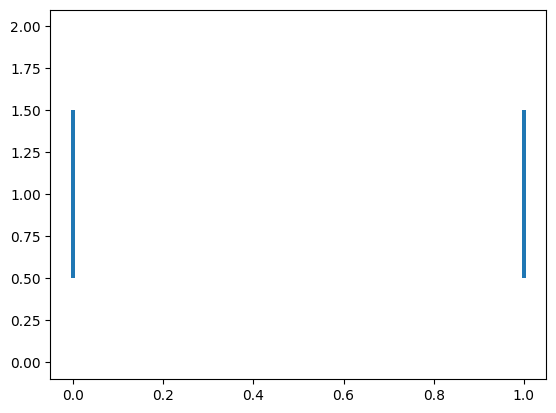

In [262]:
raster_seq=repeat_vis(dat_colony1)
#df=pd.DataFrame()
df1=pd.DataFrame()
for i in range(len(raster_seq)):
    x=(list(raster_seq[i]))
    for i in range(len(x)):
        x[i]=int(x[i])
    #x= [np.nan if i == 0 else i for i in x]
    plt.eventplot(x)
    df=pd.DataFrame(x)
    df1=pd.concat([df1,df],axis=1)
df1=df1.T

In [263]:
len(raster_seq)

80

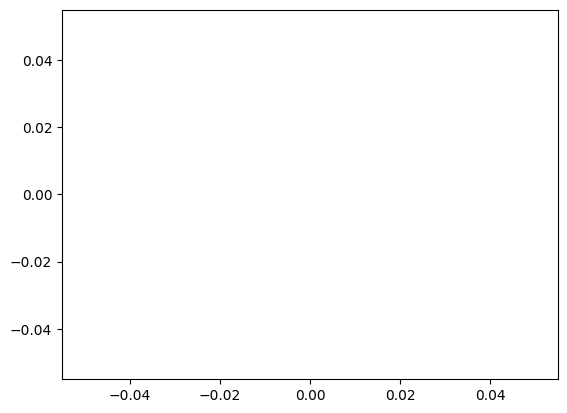

In [256]:
df1
y=df1.iloc[0]
plt.eventplot(y)

In [264]:
df1.to_csv('raster_before_col1.csv')

In [51]:
seq_list=dat_colony2['note sequence']
seq=(seq_list[2])

seq_new= seq.replace('d','1').replace("a","0")
seq_new

'b0bbb0b0c1cebebb0bbbcfc0bc'

In [50]:
rep={"d":"1","a":"","b":"0","c":"0","e":"0","f":"0","m":"0"}
seq_new=replace_all(seq,rep)

NameError: name 'replace_all' is not defined

In [30]:
raster_seq

['bbbddcb0cb',
 'bab0bbbbbbbbeebebbcebb',
 'babbbabacdcebebbabbbcfcabc',
 'eeba0bdbbbeeecddddcaaecdeccaaddddddaefefbmefbbbbbebeefefceccbfebeebdddddbbbedbfbbbaddddddddddedceb0be0adacbeeeebedb0abeedbcdcddcddecbefebeeedbefdb',
 'eeeeeeeebbccbcebcbbbbbbbbbbcfcbfbbcfbbdbbbbbbbbbbbbdbbcbbcbfbcfbbbabbbbbbbbaedbbccebbefbbbebeccbbbbbbbbebabebbabdddeebefcccbbbebcbbeedbecbadddddbecadbebaedbedddeebdfbefdcbdbbbbbbbbbbedbfbcbbcbbbbbebbddddddebabdbbbbdcebbaaecdcddeaacbeabaefecddbabecaabacbefcccbbdddcabbededbfddddddbafbbeedaebadadcbbbddcdddeeefdeebebbfbbbbbeddddddbebfbbcbbfembabccfdbbcaddbbabefacfeebbbbbcadddddddebfebcbbbbbbccbfbeabbbbbeecbfbbbffddddddccebebccaeffefcdb0ddcbdebbcabcfabfbebdccbbbbbedbefedeebbbaebdbbbbacbbfcbebbbdcdebdfbabaafcdbaeccdddcebfbfeecddddbfbbbebbeaeeddddddbddcbcbeabddbbbabfdedeabffbffcccadaeccdddddddbbbbbaf',
 'aabaabeecdddddddddebaabecdddddddefbddeeebecadfbaaafmccdccedcccbbbbbfaaeedddddeadfbbbbbbbecbffbeddddddccccefbbbbfddcddeb0aafbfbdebffebbbbfbbbfedddddecbddddafb',
 'bccdeba

In [15]:
len(dat['note sequence'])

NameError: name 'dat' is not defined

In [16]:
cohen_rand, cohen_after, avg_cd, std_cd=random_cohen(dat_after)
cohen_rand_bf, cohen_before, avg_cdb, std_cdb= random_cohen(dat_bf)

NameError: name 'dat_after' is not defined

In [44]:
std_cd


0    0.055678
dtype: float64

0    0.056802
dtype: float64

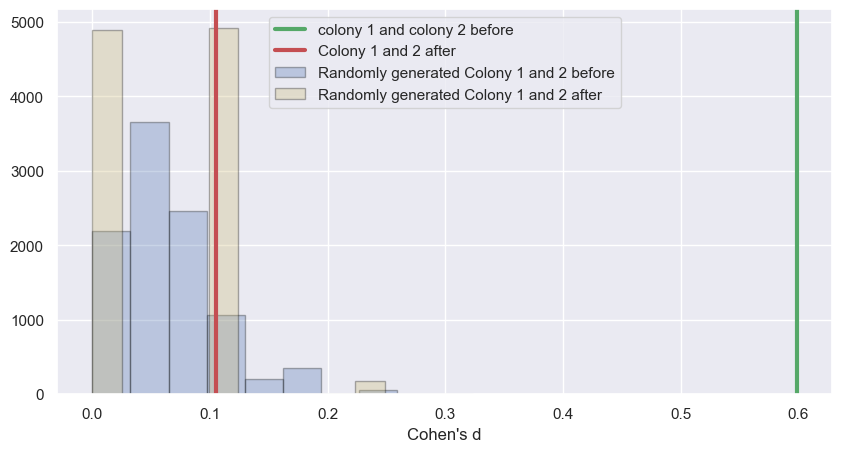

In [111]:
plt.figure(figsize=(10,5))
plt.axvline(x=0.599002, color='g', lw=3)
plt.hist(cohen_rand_bf,edgecolor='black', color='b',alpha=0.3)
plt.axvline(x=0.105103, color='r', lw=3)
plt.hist(cohen_rand, edgecolor='black', color='y',alpha=0.3)

plt.xlabel("Cohen's d")
labels=["colony 1 and colony 2 before", "Colony 1 and 2 after", "Randomly generated Colony 1 and 2 before", "Randomly generated Colony 1 and 2 after" ]
plt.legend(labels)
#plt.savefig('cohen_d_test.svg',dpi=500,bbox_inches='tight')
avg_cd
std_cd

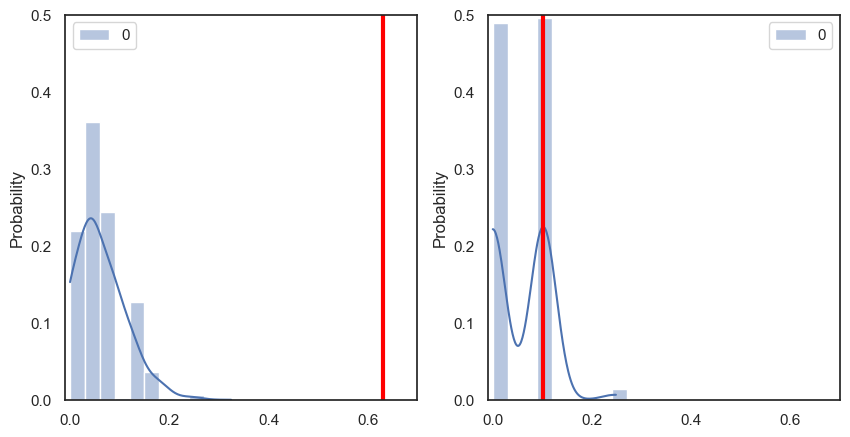

In [232]:
fig=plt.figure(figsize=(10,5))
sns.set(style='white')

plt.subplot(1,2,1)
plt.axvline(x=0.630654, color='red', lw=3)
ax1=sns.histplot(cohen_rand_bf, kde=True, binwidth=0.03, stat='probability', kde_kws=dict(bw_adjust=3), alpha=0.4)
plt.ylim([0,0.5])
plt.xlim([-0.01,0.7])

plt.subplot(1,2,2)
sns.histplot(cohen_rand, kde=True,binwidth=0.03,stat='probability', kde_kws=dict(bw_adjust=3), alpha=0.4)
#ax2=sns.displot(data=cohen_rand, color=t'darkblue',label="Randomly generated Colony 1 and 2 after", kind="kde", bw_adjust=2)
plt.axvline(x=0.101445, color='red', lw=3)
plt.ylim([0,0.5])
plt.xlim([-0.01,0.7])
plt.savefig("figures/Cohen's d test.svg", dpi=500)

In [100]:
cohen_after

0    0.101445
dtype: float64

In [16]:
prop_indd=freq_rep(dat)
#prop_indd.to_csv('Budgerigar Project_warble d repeats.csv')
prop_indd

,0,a,b,c,d,e,f,m
0,1.0,1.0,2,1.0,1.0,2.0,5.0,1.0
1,1.0,1.0,2,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1,1.0,1.0,1.0,3.0,1.0
4,1.0,1.0,2,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
4210,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
4211,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
4212,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
4213,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN


In [16]:
prop_indd

,1.0,2.0,3.0,4.0,5.0,7.0,6.0,13.0,11.0,12.0,9.0,8.0,10.0
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
ind_id=dat['ind_id']
prop_indd=prop_indd.join(ind_id)
prop_indd
#prop_indd.to_csv('Budgerigar Project_warble d repeats_nan.csv')

,1.0,2.0,3.0,4.0,5.0,7.0,6.0,13.0,11.0,12.0,9.0,8.0,10.0,ind_id
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110


In [27]:
dat

,Pair No,Date,sound box,Cage,ind,annotator,Sample ID,seq length,Warble No,Duration (s),...,Unnamed: 777,Unnamed: 778,Unnamed: 779,Unnamed: 780,Unnamed: 781,Unnamed: 782,Unnamed: 783,Unnamed: 784,Unnamed: 785,Shannon Entropy
0,1,12.06.2022,1,1,11,p,01_RO_JU_08.04_12.06.2022_01.00.00,33,1,10.354,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.839870
1,1,12.06.2022,1,1,11,p,01_RO_JU_09.04_12.06.2022_01.00.00,22,2,4.441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.286207
2,1,12.06.2022,1,1,11,p,01_RO_JU_10.04_12.06.2022_01.00.00,194,3,46.975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.912617
3,1,12.06.2022,1,1,11,p,01_RO_JU_11.04_12.06.2022_01.00.00,27,4,5.099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.235525
4,1,12.06.2022,1,1,11,p,01_RO_JU_12.04_12.06.2022_01.00.00,19,5,4.382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.371381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,14,25.06.2022,2,1,12,NaN,14_SR_SE_13.00_25.06.2022_01.00.00,58,6,14.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.733286
136,14,25.06.2022,2,1,12,NaN,14_SR_SE_14.00_25.06.2022_01.00.00,128,7,33.800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.887581
137,14,25.06.2022,2,1,12,NaN,14_SR_SE_15.00_25.06.2022_01.00.00,22,8,4.300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.360200
138,14,25.06.2022,2,1,12,NaN,14_SR_SE_16.00_25.06.2022_01.00.00,65,9,13.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770831


In [17]:
def bootstrep(df):
    notelist=get_vocab(df)
    proplist=list()
    df1=pd.DataFrame()
    df_out=pd.DataFrame()
    n=10
    for i in range(n):
        dat=df.sample(10)
        dat=dat.reset_index() # change this line depending on colony or male vs female
        occ,prop,freq=get_occurrence_freqs(dat, col_name='note sequence',
                                            note_list=get_vocab(df),
                                            win_size=3,
                                            symmetric=False)
        res=list(np.reshape(prop,(1,8)))
        #print(res)
        proplist.append(res)
    df1=np.reshape(proplist,(n,8))
    df_out=pd.DataFrame(df1)
    df_out.columns=notelist
    return df_out 

In [261]:
dat=pd.read_csv("Sequence data summer 2022 re annotation - Before dataset .csv",header=0)

dat=pd.DataFrame(dat)

## Calculating shannon entropy
H=shannon_entropy(dat, base=None)
dat['Shannon Entropy']=H
## Context-based grouping
#dat_contextseq=dat.groupby(dat['Context'])
#dat_maleseq=dat_contextseq.get_group(1)
#dat_maleseq=dat_maleseq.reset_index()
#dat_femaleseq=dat_contextseq.get_group(2)
#dat_femaleseq=dat_femaleseq.reset_index()
## Colony-based grouping
dat_colonyseq=dat.groupby(dat['Cage'])
dat_colony1=dat_colonyseq.get_group(1)
dat_colony2=dat_colonyseq.get_group(2)
dat_colony1=dat_colony1.reset_index()
dat_colony2=dat_colony2.reset_index()

#dat_combined=pd.DataFrame({dat_maleseq,dat_femaleseq,dat_colony1,dat_colony2})

In [26]:
dat_colony1


,index,Pair No,Date,Context,Cage,annotator,ind,Sample ID,seq length,Warble No,...,Unnamed: 956,Unnamed: 957,Unnamed: 958,Unnamed: 959,Unnamed: 960,Unnamed: 961,Unnamed: 962,Unnamed: 963,Unnamed: 964,Shannon Entropy
0,0,1,20-22 Sep,1,1,p,100,19700101_000936 - 19700101_002410,33,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.741215
1,1,1,NaN,1,1,p,100,19700101_013253 - 19700101_015725,19,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.867880
2,2,1,NaN,1,1,p,100,19700101_023237-19700101_025709,16,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.634759
3,3,1,NaN,1,1,p,100,19700101_030957-19700101_33117,17,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.758243
4,4,1,NaN,1,1,p,100,19700101_040941-19700101_042229,40,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.858126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,145,9,NaN,2,1,NaN,11,19700115_054555-19700115_055522,76,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.698919
76,146,9,NaN,2,1,NaN,11,19700115_200758-19700115_202034,30,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.307748
77,147,9,NaN,2,1,NaN,11,1970115_210646-19700115_211922,70,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.523149
78,148,9,NaN,2,1,NaN,11,19700115_221913-19700115_223458,41,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.690269


In [20]:
dat_bf=pd.read_csv('Sequence data summer 2022 re annotation - Before dataset .csv', header=0)

In [21]:
dat_bf

,Pair No,Date,Context,Cage,annotator,ind,Sample ID,seq length,Warble No,Duration (s),...,Unnamed: 955,Unnamed: 956,Unnamed: 957,Unnamed: 958,Unnamed: 959,Unnamed: 960,Unnamed: 961,Unnamed: 962,Unnamed: 963,Unnamed: 964
0,1,20-22 Sep,1,1,p,100,19700101_000936 - 19700101_002410,33,1,8.7349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,1,1,p,100,19700101_013253 - 19700101_015725,19,2,5.9776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,1,1,p,100,19700101_023237-19700101_025709,16,3,6.7546,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,1,1,p,100,19700101_030957-19700101_33117,17,4,5.6827,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,1,1,p,100,19700101_040941-19700101_042229,40,5,9.4586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,18,NaN,2,2,NaN,23,19700103_052117-19700103_053044,22,6,4.5192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,18,NaN,2,2,NaN,23,19700103_200523-19700103_202108,21,7,5.3486,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,18,NaN,2,2,NaN,23,19700103_204826-19700103_210308,17,8,5.3925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,18,NaN,2,2,NaN,23,19700103_214817-19700103_220156,29,9,5.6359,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
dat_after=pd.read_csv('Sequence data summer 2022 re annotation - After dataset.csv',header=0)

In [26]:
dat.to_csv('Budgie project before modified.csv')


To save individual wise data for Kruskal-Wallis Test on Shannon Entropy. Only run the cell below cell when you want to save the individual wise data to a csv file as all male-male rows are deleted from the dataframe if you do this

In [21]:
dat.drop(dat[dat['ind']==100].index, inplace=True)
dat.to_csv('Budgerigar Project- ind data.csv')

The cell below calculates the length of warble excluding silent periods

In [14]:
note_seq=dat['note sequence']
xlen=list()
note_len=pd.DataFrame()
for i in range(len(note_seq)):
    x=len(note_seq[i])-note_seq[i].count('0')
    #print(x)
    xlen.append(x)
#note_len=note_len.transpose
note_len=pd.DataFrame(xlen)
note_len.to_csv('warble length.csv')

In [14]:
dat_col1=dat_colony1.groupby(['Context'])
dat_col1m=dat_col1.get_group(1)
dat_col1f=dat_col1.get_group(2)
dat_col1m=dat_col1m.reset_index()
dat_col1f=dat_col1f.reset_index()

dat_col2=dat_colony2.groupby(['Context'])
#dat_col2m=dat_col2.get_group(1)
dat_col2f=dat_col2.get_group(2)
#dat_col2m=dat_col2m.reset_index()
dat_col2f=dat_col2f.reset_index()

In [15]:
## Individual based grouping from different colonies

dat_colony_ind=dat.groupby(dat['Pair No'])
dat_ind1=dat_colony_ind.get_group(1)
dat_ind2=dat_colony_ind.get_group(2)
dat_ind8=dat_colony_ind.get_group(8)
dat_ind1=dat_ind1.reset_index()
dat_ind2=dat_ind2.reset_index()
dat_ind8=dat_ind8.reset_index()

In [22]:
dat_colony2


,index,pair no(after),pair no(before),Date,sound box,Context,Cage,ind,annotator,Sample ID,...,Unnamed: 779,Unnamed: 780,Unnamed: 781,Unnamed: 782,Unnamed: 783,Unnamed: 784,Unnamed: 785,Unnamed: 786,Unnamed: 787,Shannon Entropy
0,20,3,12,15.06.2022,1.0,2,2,21,NaN,03_EV_SA_08.00_15.06.2022_01.00.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.843967
1,21,3,12,15.06.2022,1.0,2,2,21,NaN,03_EV_SA_09.00_15.06.2022_01.00.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.874475
2,22,3,12,15.06.2022,1.0,2,2,21,NaN,03_EV_SA_10.00_15.06.2022_00.46.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.764890
3,23,3,12,15.06.2022,1.0,2,2,21,NaN,03_EV_SA_11.03_15.06.2022_00.43.31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.874033
4,24,3,12,14.06.2022,1.0,2,2,21,NaN,03_EV_SA_12.00_14.06.2022_01.00.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.875102
5,25,3,12,14.06.2022,1.0,2,2,21,NaN,03_EV_SA_13.00_14.06.2022_01.00.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.866775
6,26,3,12,14.06.2022,1.0,2,2,21,NaN,03_EV_SA_14.00_14.06.2022_01.00.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.546407
7,27,3,12,14.06.2022,1.0,2,2,21,NaN,03_EV_SA_15.00_14.06.2022_01.00.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.780669
8,28,3,12,14.06.2022,1.0,2,2,21,NaN,03_EV_SA_16.00_14.06.2022_01.00.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.860090
9,29,3,12,14.06.2022,1.0,2,2,21,NaN,03_EV_SA_17.00_14.06.2022_01.00.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.905417


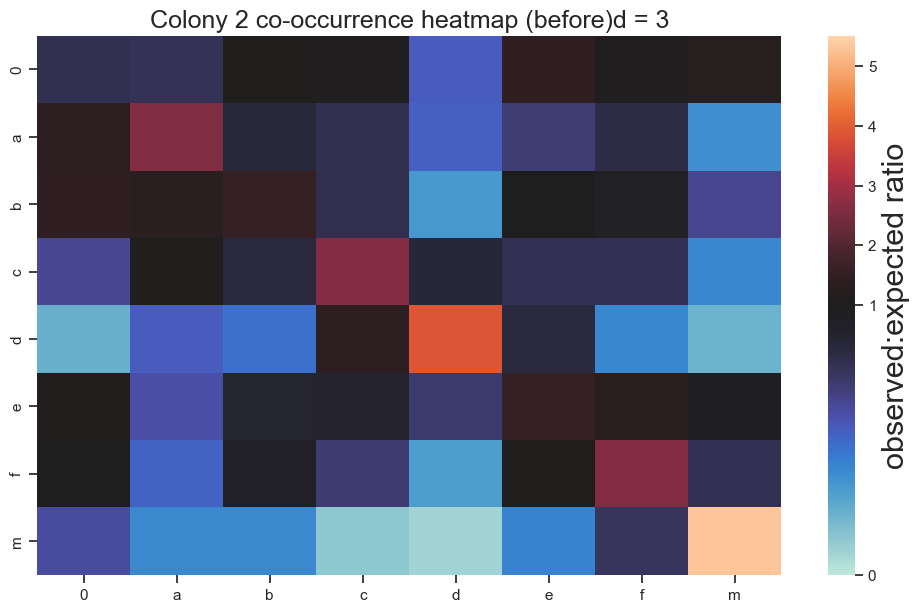

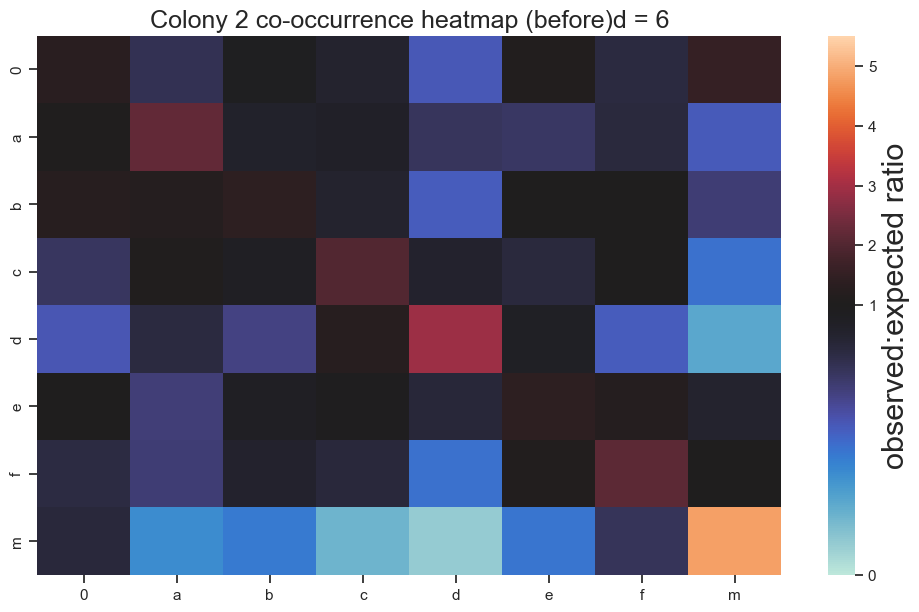

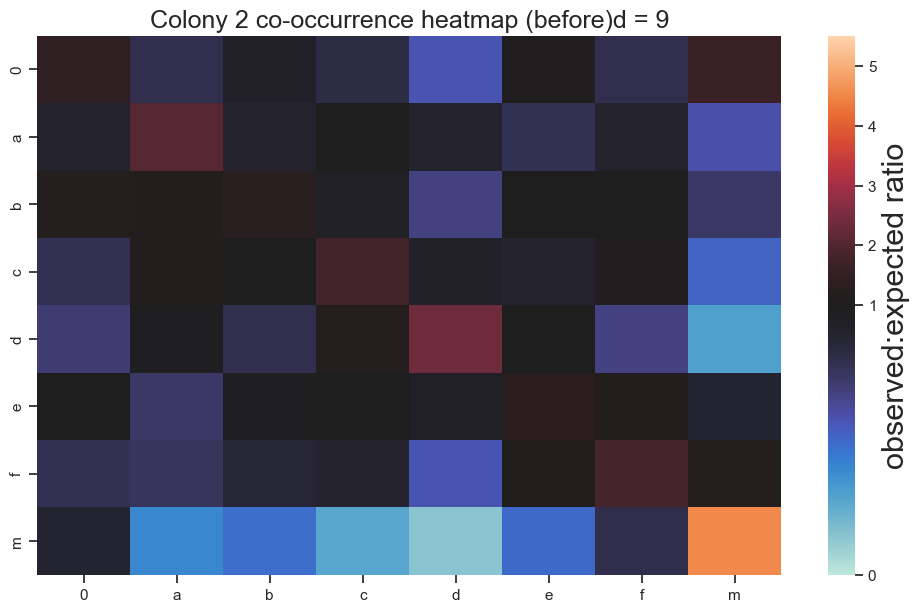

In [89]:
winsize_max=9

for win in range(round(winsize_max/3),winsize_max+1,round(winsize_max/3)): #Take three possible d values
        obs, exp = check_for_co_occurrence(dat_colony2, # change variable depending on the co-occurence matrix needed
                                       col_name='note sequence',
                                       note_list=get_vocab(dat_colony2),
                                       win_size=win,
                                       runs=500,
                                       symmetric=False)
    
        #max_allowed = min(25,max((normalized_deviation(obs, exp, np.inf)).max()))
        max_allowed=5.5

        make_heatmap(normalized_deviation(obs, exp, max_allowed),
                 get_vocab(dat),
                 max_allowed=max_allowed,
                 title='Colony 2 co-occurrence heatmap (before)' + 'd = ' + str(win), # Title corresponding to context/Colony
                 save=True,
                 file = 'heatmaps/'+'colony 2_heatmap_before'+'d_'+str(win)+'v3') # Title corresponding to Context/Colony


In [38]:
obs, exp = check_for_co_occurrence(dat_colony2, # change variable depending on the co-occurence matrix needed
                                   col_name='note sequence',
                                   note_list=get_vocab(dat_colony2),
                                   win_size=9,
                                   runs=500,
                                   symmetric=False)
max_allowed=5.5
col2_co_occ_9=normalized_deviation(obs, exp, max_allowed)

In [37]:
col2_co_occ_9.columns=get_vocab(dat_colony2)
col2_co_occ_9.index=get_vocab(dat_colony2)
col2_co_occ_9.to_csv('col2_co_occ_9.csv')

In [ ]:
## Behavioural context and levenshtein Distance

# calculating pair-wise Levenshtein Distance between warbles in male-male context

lev_male=np.zeros((len(dat_maleseq),len(dat_maleseq)))
for i in range(len(dat_maleseq)) :
    for j in range(len(dat_maleseq)):
        lev_male[i,j]=leven(dat_maleseq['note sequence'][i],dat_maleseq['note sequence'][j])

# calculating pair-wise Levenshtein Distance between warbles in male-female context

lev_female=np.zeros((len(dat_femaleseq),len(dat_femaleseq)))
for i in range(len(dat_femaleseq)) :
    for j in range(len(dat_femaleseq)):
        lev_female[i,j]=leven(dat_femaleseq['note sequence'][i],dat_femaleseq['note sequence'][j])



## taking only upper triangle as distance is symmetric and converting it to 1D array
lev_m= lev_male[np.triu_indices(lev_male.shape[0], k = 1)]
lev_f=lev_female[np.triu_indices(lev_female.shape[0], k=1)]

# calculating pair-wise Levenshtein Distance between warbles in male-male and male-female context
lev_mm_f=np.zeros((len(dat_maleseq),len(dat_femaleseq)))
for i in range(len(dat_maleseq)):
    for j in range(len(dat_femaleseq)):
        lev_mm_f[i,j]=leven(dat_maleseq['note sequence'][i],dat_femaleseq['note sequence'][j])
lev_mmf=lev_mm_f.flatten() #2D to 1D-array

In [185]:
# plottig distribution of levenshtein distances for the 3 cases
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
sns.histplot(data=lev_m, color="darkblue", label="male-male", kde=True,alpha=0.7)
sns.histplot(data=lev_f , color="red", label="male-female", kde=True,alpha=0.7)
sns.histplot(data=lev_mmf, color="yellow", label="male-male and male-female", kde=True, alpha=0.5)
sns.set(font_scale=1.5)
plt.xlabel('Levenshtein Distance',fontsize=20)
plt.ylabel('Frequency Count',fontsize=20)
plt.title("Distribution of Levenshtein Distance between \nwarble sequences in different Behavioural Contexts", fontsize=25)
plt.legend() 
plt.show()

NameError: name 'lev_m' is not defined

<Figure size 1500x1000 with 0 Axes>

In [16]:
## Colony and Levenshtein Distance

lev_1=np.zeros((len(dat_colony1),len(dat_colony1)))
for i in range(len(dat_colony1)) :
    for j in range(len(dat_colony1)):
        #print(dat_maleseq['note sequence'][i])
        #print(dat_maleseq['note sequence'][j])
        lev_1[i,j]=leven(dat_colony1['note sequence'][i],dat_colony1['note sequence'][j])



lev_2=np.zeros((len(dat_colony2),len(dat_colony2)))
for i in range(len(dat_colony2)) :
    for j in range(len(dat_colony2)):
        #print(dat_femaleseq['note sequence'][i])
        #print(dat_femaleseq['note sequence'][j])
        lev_2[i,j]=leven(dat_colony2['note sequence'][i],dat_colony2['note sequence'][j])



## taking only upper triangle as distance is symmetric
lev_1= lev_1[np.triu_indices(lev_1.shape[0], k = 1)]
lev_2=lev_2[np.triu_indices(lev_2.shape[0], k=1)]
lev_12=np.zeros((len(dat_colony1),len(dat_colony2)))
for i in range(len(dat_colony1)):
    for j in range(len(dat_colony2)):
        lev_12[i,j]=leven(dat_colony1['note sequence'][i],dat_colony2['note sequence'][j])
lev_12=lev_12.flatten()        


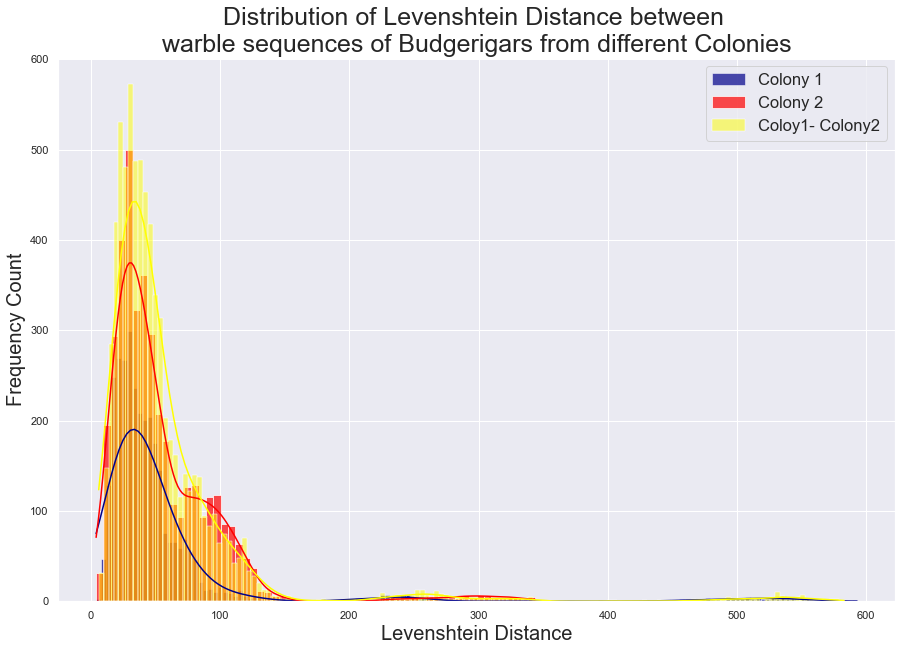

In [17]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
sns.histplot(data=lev_1, color="darkblue", label="Colony 1", kde=True,alpha=0.7)
sns.histplot(data=lev_2 , color="red", label="Colony 2", kde=True,alpha=0.7)
sns.histplot(data=lev_12, color="yellow", label="Coloy1- Colony2", kde=True, alpha=0.5)
sns.set(font_scale=1.5)
plt.xlabel('Levenshtein Distance',fontsize=20)
plt.ylabel('Frequency Count',fontsize=20)
plt.title("Distribution of Levenshtein Distance between \nwarble sequences of Budgerigars from different Colonies", fontsize=25)
plt.legend() 
plt.show()

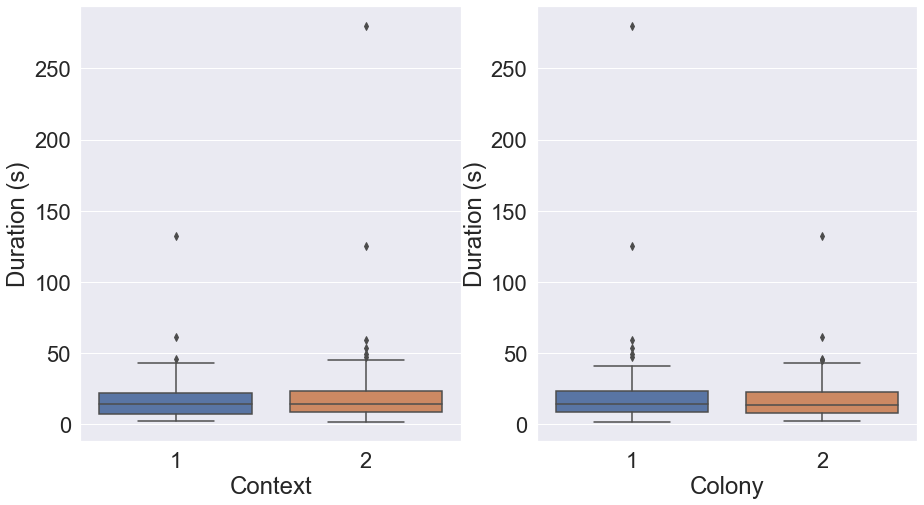

In [51]:
# Duration plots
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
fig=plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
ax1=sns.boxplot(x='Context',y='Duration (s)', data=dat)
plt.subplot(1,2,2)
ax2=sns.boxplot(x='Cage',y='Duration (s)', data=dat)
ax2.set_xlabel('Colony')
plt.savefig('Duration.png',dpi=500,bbox_inches="tight")

In [57]:
## Proportion of each note type
occ,marginal_probm=get_occurrence_freqs(dat_maleseq,
                            col_name='note sequence',
                            note_list=get_vocab(dat_maleseq),
                            win_size=3,
                            symmetric=False)
occf,marginal_probf=get_occurrence_freqs(dat_femaleseq,
                            col_name='note sequence',
                            note_list=get_vocab(dat_femaleseq),
                            win_size=3,
                            symmetric=False)

NameError: name 'dat_maleseq' is not defined

C:\Users\ANANDK~1\AppData\Local\Temp/ipykernel_4880/2093942628.py:7: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax2=plt.pie(x=marginal_probf, autopct="%.1f%%", labels=get_vocab(dat_femaleseq), pctdistance=0.5,textprops={'fontsize': 20})


Text(0.5, 1.0, 'Male-Female')

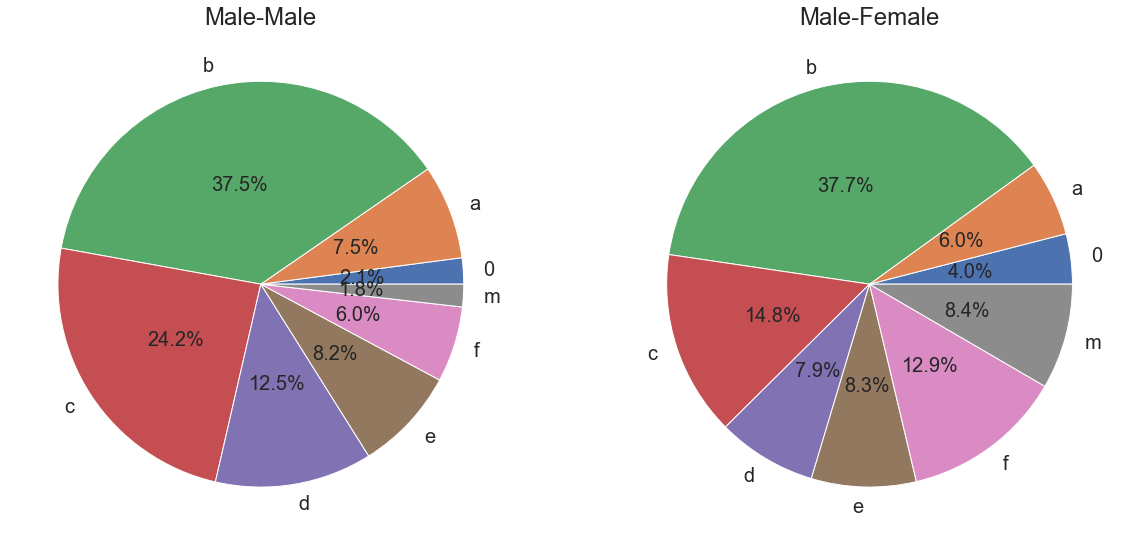

In [31]:
## Plotting pie chart depicting note type proportions
fig=plt.figure(0,figsize=(20,20))
plt.subplot(1,2,1)
ax1=plt.pie(x=marginal_probm, autopct="%.1f%%", labels=get_vocab(dat_maleseq), pctdistance=0.5,textprops={'fontsize': 20})
plt.title('Male-Male')
plt.subplot(1,2,2)
ax2=plt.pie(x=marginal_probf, autopct="%.1f%%", labels=get_vocab(dat_femaleseq), pctdistance=0.5,textprops={'fontsize': 20})
plt.title('Male-Female')

In [58]:
## Proportion of each note type
occ,marginal_prob1=get_occurrence_freqs(dat_colony1,
                            col_name='note sequence',
                            note_list=get_vocab(dat_colony1),
                            win_size=3,
                            symmetric=False)
occf,marginal_prob2=get_occurrence_freqs(dat_colony2,
                            col_name='note sequence',
                            note_list=get_vocab(dat_colony2),
                            win_size=3,
                            symmetric=False)

In [59]:
marginal_prob2

array([0.02722349, 0.06808248, 0.34103003, 0.07967503, 0.20562524,
       0.16281832, 0.06594451, 0.04960091])

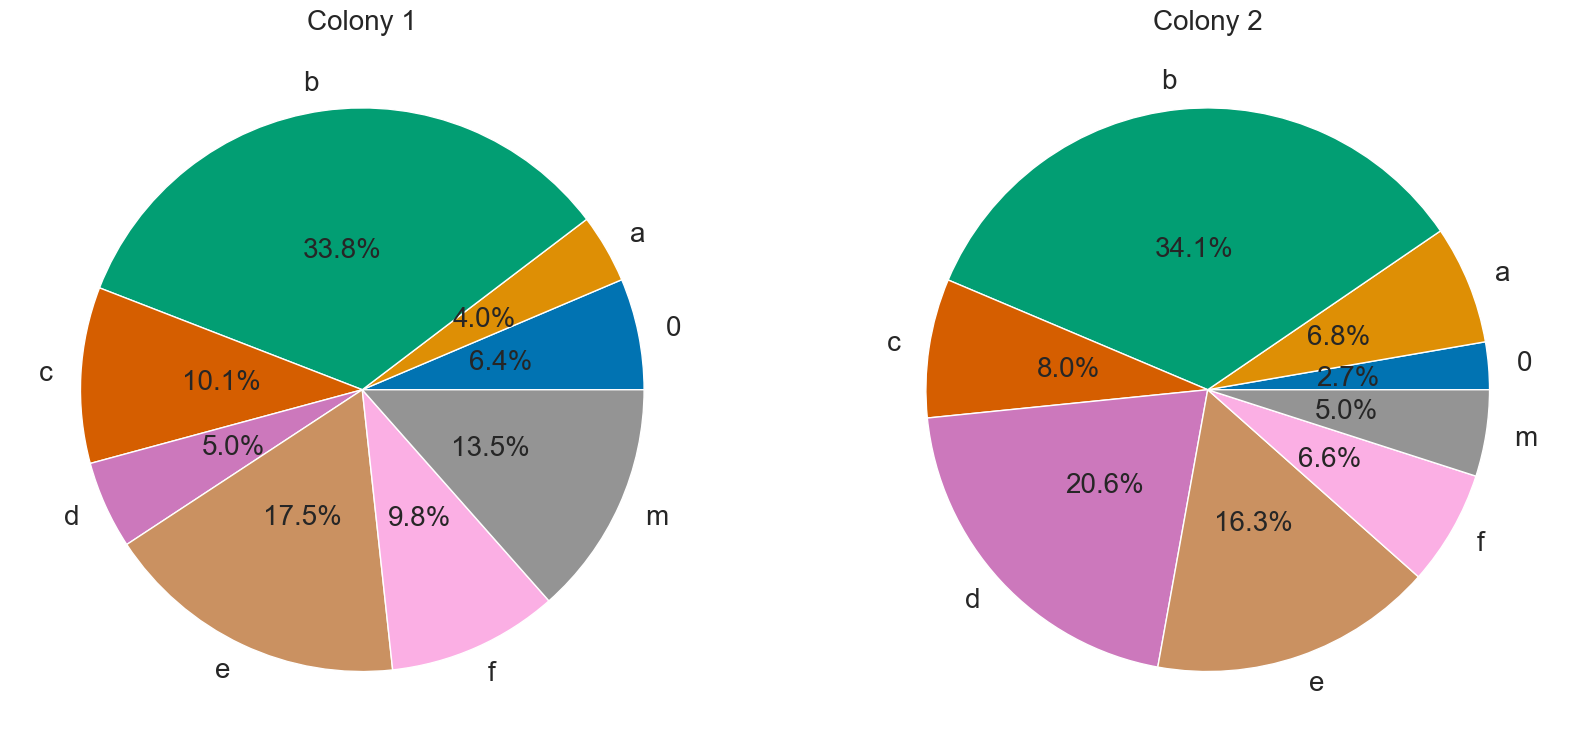

In [61]:
## Plotting pie chart depicting note type proportions
fig=plt.figure(0,figsize=(20,20))
colors=sns.color_palette("colorblind")
plt.subplot(1,2,1)
ax1=plt.pie(x=marginal_prob1, autopct="%.1f%%", labels=get_vocab(dat_colony1), pctdistance=0.5,textprops={'fontsize': 20}, colors=colors)
plt.title('Colony 1', fontsize=20)
plt.subplot(1,2,2)
ax2=plt.pie(x=marginal_prob2, autopct="%.1f%%", labels=get_vocab(dat_colony2), pctdistance=0.5,textprops={'fontsize': 20}, colors=colors)
plt.title('Colony 2', fontsize=20)
plt.savefig("figures/Note proportions_colony_before_v3.svg", dpi=500, bbox_inches="tight")

In [21]:
marginal_prob1=pd.DataFrame(marginal_prob1)
marginal_prob1.index=get_vocab(dat_colony1)

marginal_prob2=pd.DataFrame(marginal_prob2)
marginal_prob2.index=get_vocab(dat_colony2)

marginal_prob1.to_csv('col1_noteproportions.csv')

marginal_prob2.to_csv('col2_noteproportions.csv')
note_prop=pd.concat([marginal_prob1,marginal_prob2], axis=1)
note_prop.columns=['Colony 1', 'Colony 2']
note_prop.to_csv('noteproportions.csv')

note_freq1=pd.DataFrame(note_freq1)
note_freq1.index=get_vocab(dat_colony1)
note_freq2=pd.DataFrame(note_freq2)
note_freq2.index=get_vocab(dat_colony2)

note_freq=pd.concat([note_freq1,note_freq2], axis=1)
note_freq.columns=['Colony1', 'Colony2']
note_freq.to_csv('notefrequencies.csv')

In [24]:
chival,p,df,exp=chi2_contingency(note_prop)
chival,p,df,exp

(0.2007213364667486,
 0.9999745318739474,
 7,
 array([[0.04045298, 0.04045298],
        [0.05881729, 0.05881729],
        [0.36086547, 0.36086547],
        [0.16062848, 0.16062848],
        [0.08595836, 0.08595836],
        [0.09646754, 0.09646754],
        [0.10660751, 0.10660751],
        [0.09020236, 0.09020236]]))

In [37]:
marginal_prob1

,0
0,0.056867
a,0.040357
b,0.339902
c,0.110302
d,0.050654
e,0.110776
f,0.136635
m,0.154506


In [67]:
## Proportion of each note type
occ,marginal_prob_ind1=get_occurrence_freqs(dat_ind1,
                            col_name='note sequence',
                            note_list=get_vocab(dat_ind1),
                            win_size=3,
                            symmetric=False)
occf,marginal_prob_ind2=get_occurrence_freqs(dat_ind2,
                            col_name='note sequence',
                            note_list=get_vocab(dat_ind2),
                            win_size=3,
                            symmetric=False)
occf,marginal_prob_ind8=get_occurrence_freqs(dat_ind8,
                            col_name='note sequence',
                            note_list=get_vocab(dat_ind8),
                            win_size=3,
                            symmetric=False)


Text(0.5, 1.0, 'plb1m X sat1f')

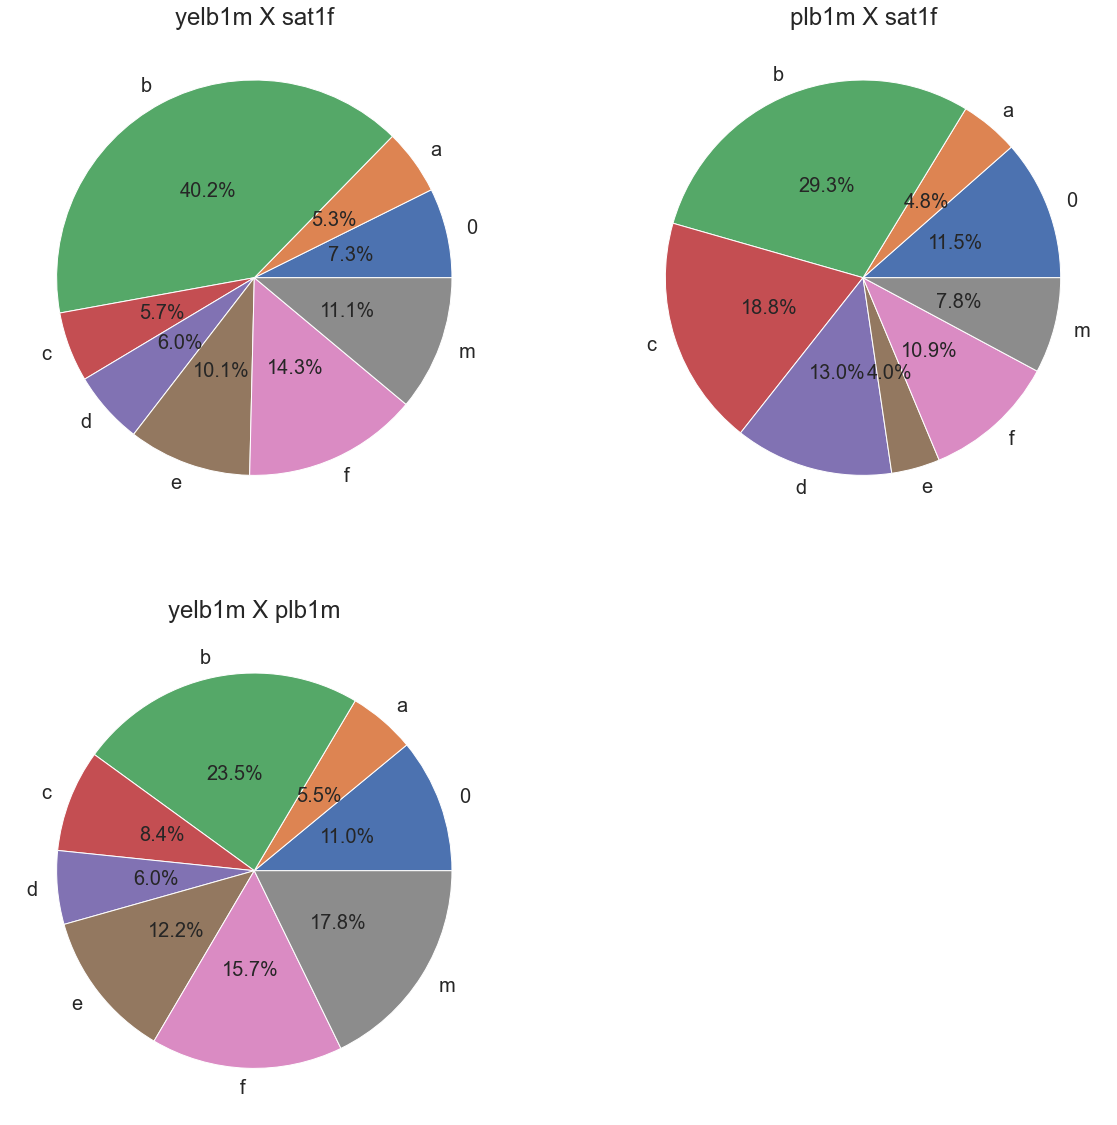

In [68]:
fig=plt.figure(0,figsize=(20,20))
plt.subplot(2,2,3)
ax1=plt.pie(x=marginal_prob_ind1, autopct="%.1f%%", labels=get_vocab(dat_ind1), pctdistance=0.5,textprops={'fontsize': 20})
plt.title('yelb1m X plb1m')
plt.subplot(2,2,1)
ax2=plt.pie(x=marginal_prob_ind2, autopct="%.1f%%", labels=get_vocab(dat_ind2), pctdistance=0.5,textprops={'fontsize': 20})
plt.title('yelb1m X sat1f')
plt.subplot(2,2,2)
ax2=plt.pie(x=marginal_prob_ind8, autopct="%.1f%%", labels=get_vocab(dat_ind8), pctdistance=0.5,textprops={'fontsize': 20})
plt.title('plb1m X sat1f')

In [15]:
## Proportion of each note type
occ,marginal_prob1m, note_freq1m=get_occurrence_freqs(dat_col1m,
                            col_name='note sequence',
                            note_list=get_vocab(dat_col1m),
                            win_size=3,
                            symmetric=False)
occf,marginal_prob1f, note_freq1f=get_occurrence_freqs(dat_col1f,
                            col_name='note sequence',
                            note_list=get_vocab(dat_col1f),
                            win_size=3,
                            symmetric=False)
## Proportion of each note type
occ,marginal_prob2m, note_freq2m=get_occurrence_freqs(dat_col2m,
                            col_name='note sequence',
                            note_list=get_vocab(dat_col2m),
                            win_size=3,
                            symmetric=False)
occf,marginal_prob2f, note_freq2f=get_occurrence_freqs(dat_col2f,
                            col_name='note sequence',
                            note_list=get_vocab(dat_col2f),
                            win_size=3,
                            symmetric=False)

In [17]:
note_freq1m=pd.DataFrame(note_freq1m)
note_freq1m.index=get_vocab(dat_colony1)
note_freq1f=pd.DataFrame(note_freq1f)
note_freq1f.index=get_vocab(dat_colony1)

note_freq2m=pd.DataFrame(note_freq2m)
note_freq2m.index=get_vocab(dat_colony2)
note_freq2f=pd.DataFrame(note_freq2f)
note_freq2f.index=get_vocab(dat_colony2)
note_freqcol1=pd.concat([note_freq1m,note_freq1f], axis=1)
note_freqcol1.columns=['Male-Male', 'Male-Female']
#note_freqcol1.to_csv('notefrequencies colony1.csv')

In [31]:
marginal_prob1m=pd.DataFrame(marginal_prob1m)
marginal_prob1m.index=get_vocab(dat_colony1)

marginal_prob1f=pd.DataFrame(marginal_prob1f)
marginal_prob1f.index=get_vocab(dat_colony1)

marginal_prob2m=pd.DataFrame(marginal_prob2m)
marginal_prob2m.index=get_vocab(dat_colony1)

marginal_prob2f=pd.DataFrame(marginal_prob2f)
marginal_prob2f.index=get_vocab(dat_colony1)

note_propcol1=pd.concat([marginal_prob1m,marginal_prob1f], axis=1)
note_propcol1.columns=['Male-Male', 'Male-Female']

note_propcol2=pd.concat([marginal_prob2m,marginal_prob2f], axis=1)
note_propcol2.columns=['Male-Male', 'Male-Female']

In [33]:
note_propcol2.to_csv('noteproportions col2.csv')
note_propcol1.to_csv('noteproportions col1.csv')

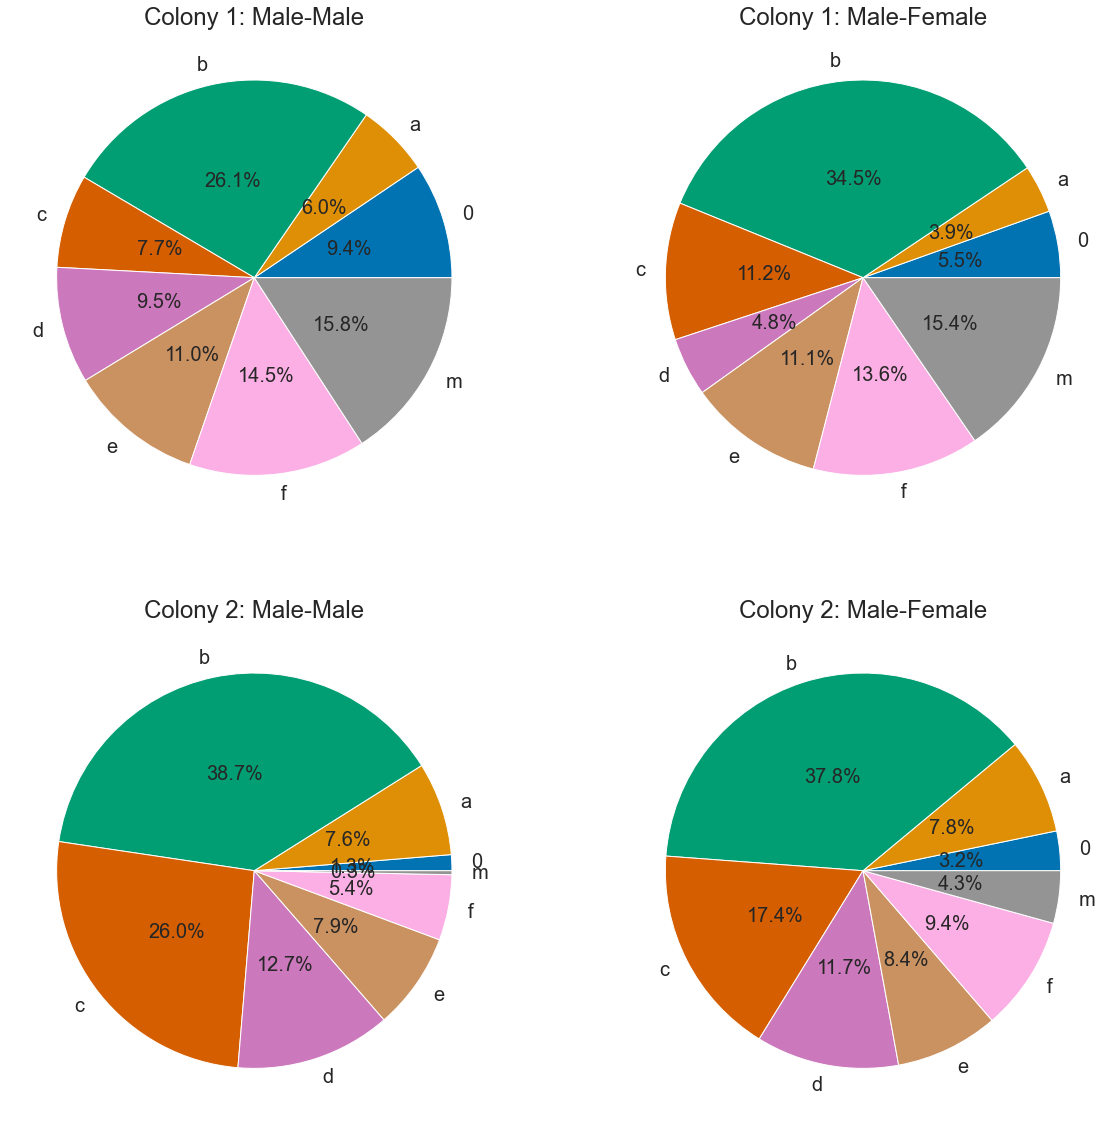

In [97]:
## Plotting pie chart depicting note type proportions
fig=plt.figure(0,figsize=(20,20))
colors=sns.color_palette("colorblind")
plt.subplot(2,2,1)
ax1=plt.pie(x=marginal_prob1m, autopct="%.1f%%", labels=get_vocab(dat_col1m), pctdistance=0.5,textprops={'fontsize': 20},colors=colors)
plt.title('Colony 1: Male-Male')
plt.subplot(2,2,2)
ax2=plt.pie(x=marginal_prob1f, autopct="%.1f%%", labels=get_vocab(dat_col1f), pctdistance=0.5,textprops={'fontsize': 20},colors=colors)
plt.title('Colony 1: Male-Female')
plt.subplot(2,2,3)
ax1=plt.pie(x=marginal_prob2m, autopct="%.1f%%", labels=get_vocab(dat_col2m), pctdistance=0.5,textprops={'fontsize': 20},colors=colors)
plt.title('Colony 2: Male-Male')
plt.subplot(2,2,4)
ax2=plt.pie(x=marginal_prob2f, autopct="%.1f%%", labels=get_vocab(dat_col2f), pctdistance=0.5,textprops={'fontsize': 20},colors=colors)
plt.title('Colony 2: Male-Female')
plt.savefig("figures/Note proportions.png", dpi=500, bbox_inches="tight")

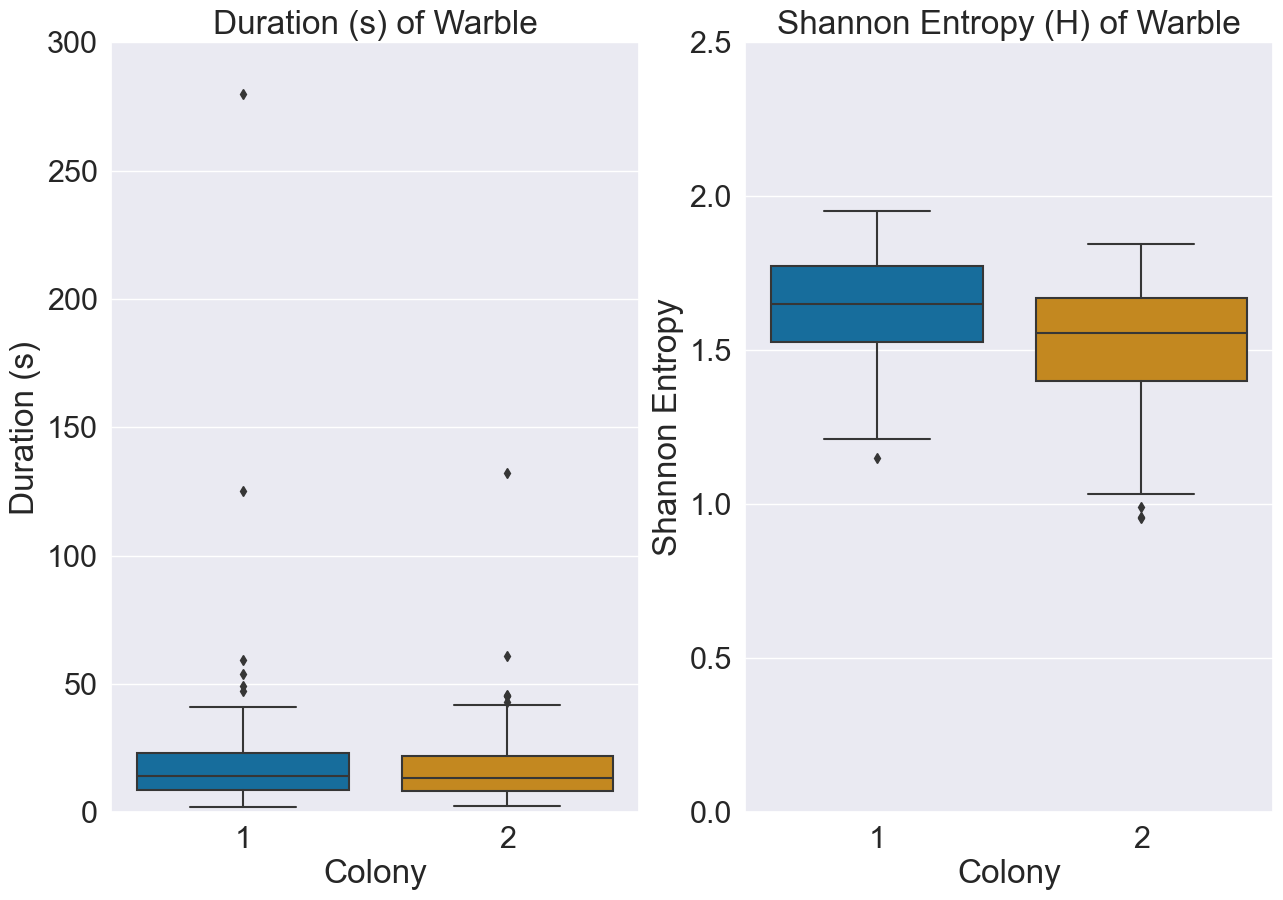

In [63]:
# Box plot for Shannon Entropy
sns.set_theme(style="ticks")
sns.set(font_scale=2)
fig=plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
ax1=sns.boxplot(x='Cage',y='Duration (s)' , data=dat, palette="colorblind")
plt.ylim([0,300])
ax1.set_xlabel("Colony")
plt.title("Duration (s) of Warble")

plt.subplot(1,2,2)
ax2=sns.boxplot(x='Cage', y='Shannon Entropy',data=dat,palette="colorblind")
plt.title("Shannon Entropy (H) of Warble")
plt.ylim([0,2.5])
ax2.set_xlabel("Colony")


plt.savefig("figures/Box-Plot_before_v3.svg", dpi=500, bbox_inches="tight")


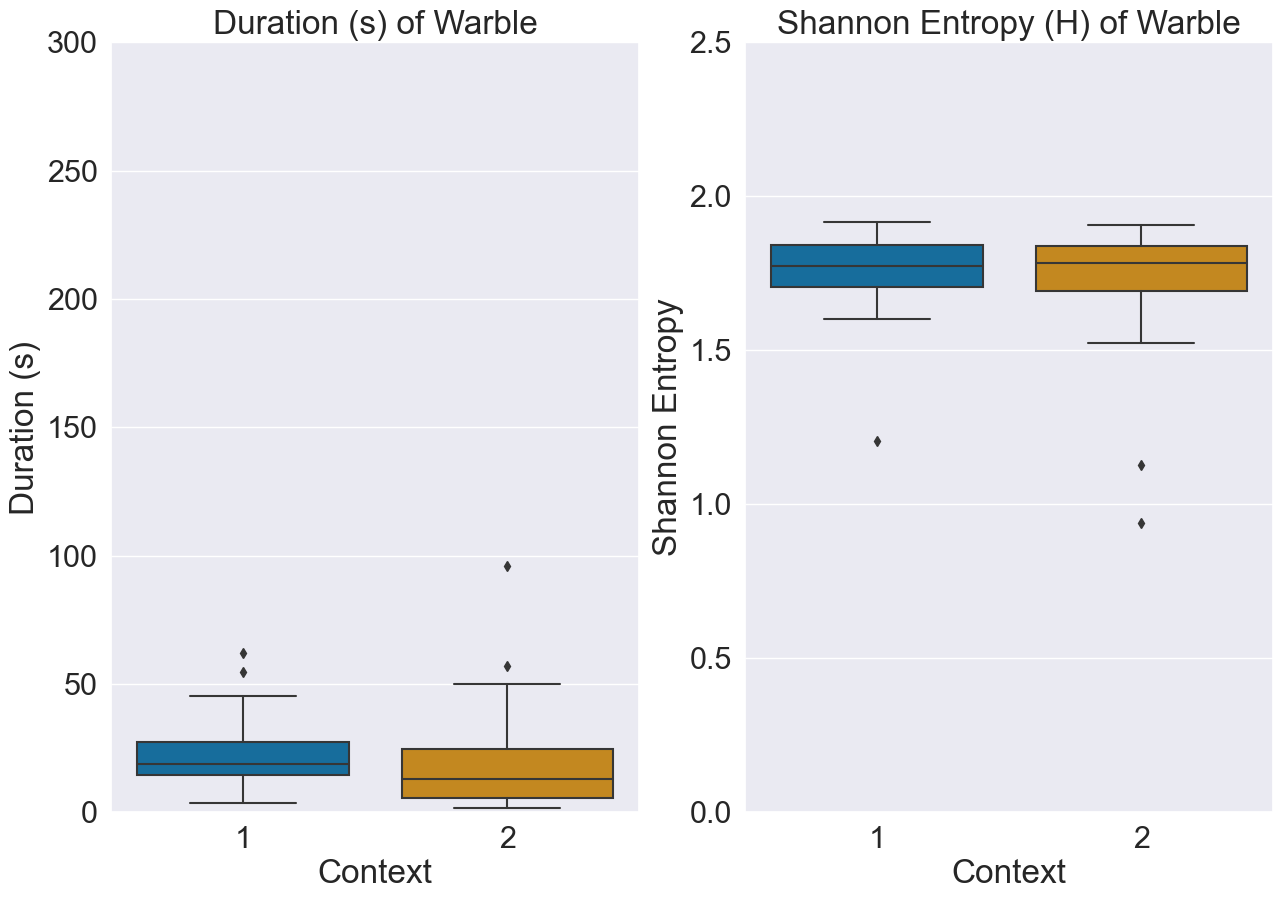

In [21]:
# Box plot for Shannon Entropy
sns.set_theme(style="ticks")
sns.set(font_scale=2)
fig=plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
ax1=sns.boxplot(x='Context',y='Duration (s)' , data=dat_colony2, palette="colorblind")
plt.ylim([0,300])
ax1.set_xlabel("Context")
plt.title("Duration (s) of Warble")

plt.subplot(1,2,2)
ax2=sns.boxplot(x='Context', y='Shannon Entropy',data=dat_colony2,palette="colorblind")
plt.title("Shannon Entropy (H) of Warble")
plt.ylim([0,2.5])
ax2.set_xlabel("Context")

plt.savefig("figures/colony2_context.svg", bbox_inches='tight', dpi=500)

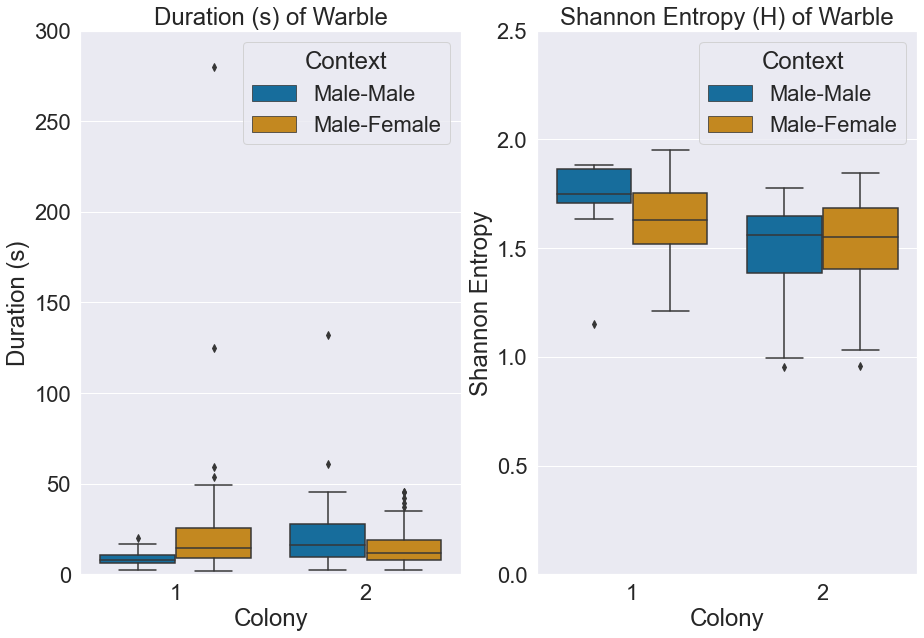

In [21]:
# Box plot for Shannon Entropy
sns.set_theme(style="white")
sns.set(font_scale=2)
fig=plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
ax1=sns.boxplot(x='Cage',y='Duration (s)', hue="Context" , data=dat, palette="colorblind")
new_legend=['Male-Male',"Male-Female"]
ax1.legend_.texts[0].set_text(new_legend[0])
ax1.legend_.texts[1].set_text(new_legend[1])
ax1.set_xlabel("Colony")
plt.title("Duration (s) of Warble")
plt.ylim([0,300])

plt.subplot(1,2,2)
ax2=sns.boxplot(x='Cage', y='Shannon Entropy', hue="Context",data=dat,palette="colorblind")
plt.title("Shannon Entropy (H) of Warble")
ax2.legend_.texts[0].set_text(new_legend[0])
ax2.legend_.texts[1].set_text(new_legend[1])
ax2.set_xlabel("Colony")
plt.ylim([0,2.5])


#plt.savefig("figures/Box-Plot_mf_before.svg", dpi=500, bbox_inches="tight")




In [69]:
## get avg. values for variables

dat_colony_ind=dat.groupby(dat['Pair No'])
dat_dur_mean=dat_colony_ind.mean()
dat_dur_mean

,Context,Cage,seq length,Warble No,Duration (s),Unnamed: 740,Unnamed: 754,Unnamed: 782,Unnamed: 786,Unnamed: 788,Shannon Entropy
Pair No,,,,,,,,,,,
1,1.0,1.0,32.8,5.5,9.38727,NaN,NaN,NaN,NaN,NaN,1.775182
2,2.0,1.0,57.3,5.5,16.44643,NaN,NaN,NaN,NaN,NaN,1.639059
3,2.0,1.0,77.3,5.5,20.81867,NaN,NaN,NaN,NaN,NaN,1.585642
4,2.0,1.0,103.0,5.5,30.96215,NaN,NaN,NaN,NaN,NaN,1.528569
5,2.0,1.0,57.7,5.5,19.42624,NaN,NaN,NaN,NaN,NaN,1.592425
7,2.0,1.0,126.3,5.5,42.69599,0.0,0.0,0.0,0.0,0.0,1.657355
8,2.0,1.0,59.4,5.5,18.40407,NaN,NaN,NaN,NaN,NaN,1.688411
9,2.0,1.0,57.5,5.5,18.07712,NaN,NaN,NaN,NaN,NaN,1.641518
10,1.0,2.0,122.7,5.5,26.74560,NaN,NaN,NaN,NaN,NaN,1.267985


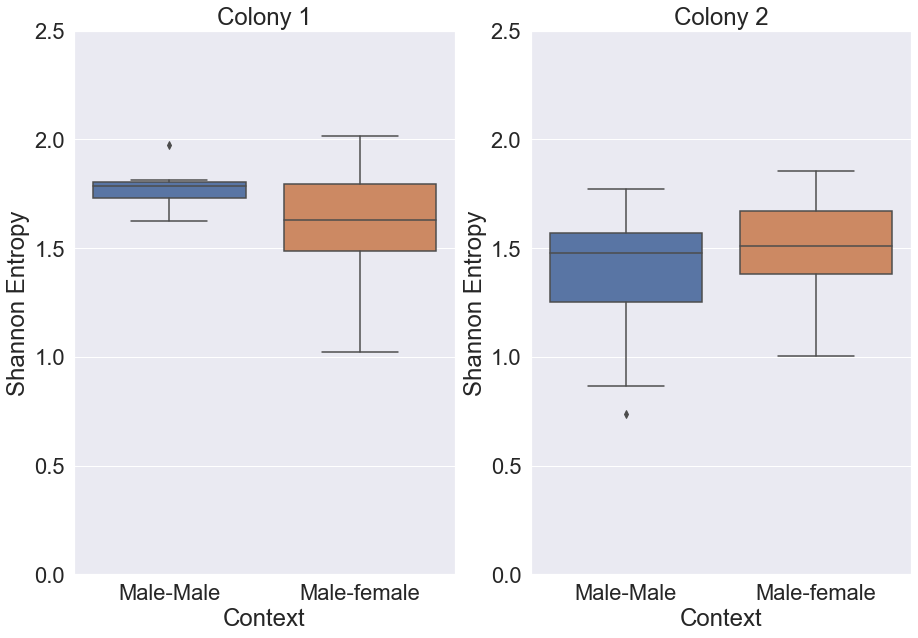

In [22]:
# Box plot for Shannon Entropy
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
fig=plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
ax1=sns.boxplot(x='Context',y='Shannon Entropy', hue="" data=dat_colony1)
plt.title("Colony 1")
plt.ylim([0,2.5])
plt.subplot(1,2,2)
ax2=sns.boxplot(x='Context', y='Shannon Entropy', data=dat_colony2)
plt.title("Colony 2")
plt.ylim([0,2.5])

plt.savefig("Shannon Entropy.png", dpi=500, bbox_inches="tight")


In [25]:
def freq_rep(df, col_name='note sequence'):
    notelist=get_vocab(df)
    seq_list=df[col_name]
    seq=seq_list[0]
    replist=list()
    df1=pd.DataFrame()
    df_out=pd.DataFrame()
    for note in notelist:
        noterep=0
        replist=list()
        for seq in seq_list:
            seq=seq+'x'
            for element in seq:
                if element == note:
                    noterep += 1
                elif (element != note):
                    replist.append(noterep)
                    noterep=0
        replist=[i for i in replist if i!=0]
        df1=pd.DataFrame({note:replist})
        df_out=pd.concat([df_out,df1],axis=1)
    return df_out

In [64]:
rep_freq1=freq_rep(dat_colony1)
rep_freq2=freq_rep(dat_colony2)
#rep_freq1=[i for i in rep_freq if i!='NaN']
rep_freq1

,0,a,b,c,d,e,f,m
0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0
1,1.0,2.0,1,1.0,1.0,2.0,1.0,2.0
2,1.0,3.0,1,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1,1.0,1.0,1.0,1.0,3.0
4,1.0,1.0,1,1.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...
1229,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
1230,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
1231,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN
1232,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN


In [27]:
freq1a=(Counter(sorted(rep_freq1['a'])))
freq1b=(Counter(sorted(rep_freq1['b'])))
freq1c=(Counter(sorted(rep_freq1['c'])))
freq1d=(Counter(sorted(rep_freq1['d'])))
freq1e=(Counter(sorted(rep_freq1['e'])))
freq1f=(Counter(sorted(rep_freq1['f'])))
freq1m=(Counter(sorted(rep_freq1['m'])))


freq2a=(Counter(sorted(rep_freq2['a'])))
freq2b=(Counter(sorted(rep_freq2['b'])))
freq2c=(Counter(sorted(rep_freq2['c'])))
freq2d=(Counter(sorted(rep_freq2['d'])))
freq2e=(Counter(sorted(rep_freq2['e'])))
freq2f=(Counter(sorted(rep_freq2['f'])))
freq2m=(Counter(sorted(rep_freq2['m'])))





In [65]:
freq1a=(rep_freq1['a']).value_counts()
freq1b=rep_freq1['b'].value_counts()
freq1c=rep_freq1['c'].value_counts()
freq1d=rep_freq1['d'].value_counts()
freq1e=rep_freq1['e'].value_counts()
freq1f=rep_freq1['f'].value_counts()

freq1m=rep_freq1['m'].value_counts()


freq2a=rep_freq2['a'].value_counts()
freq2b=rep_freq2['b'].value_counts()
freq2c=rep_freq2['c'].value_counts()
freq2d=rep_freq2['d'].value_counts()
freq2e=rep_freq2['e'].value_counts()
freq2f=rep_freq2['f'].value_counts()
freq2m=rep_freq2['m'].value_counts()


In [29]:
notelist=get_vocab(dat_colony1)
notelist


['0', 'a', 'b', 'c', 'd', 'e', 'f', 'm']

In [66]:
rep1a=pd.Series(sorted(rep_freq1['a']))
freq1a=rep1a.value_counts().sort_index(0)
rep1b=pd.Series(sorted(rep_freq1['b']))
freq1b=rep1b.value_counts().sort_index(0)
rep1c=pd.Series(sorted(rep_freq1['c']))
freq1c=rep1c.value_counts().sort_index(0)
rep1d=pd.Series(sorted(rep_freq1['d']))
freq1d=rep1d.value_counts().sort_index(0)
rep1e=pd.Series(sorted(rep_freq1['e']))
freq1e=rep1e.value_counts().sort_index(0)
rep1f=pd.Series(sorted(rep_freq1['f']))
freq1f=rep1f.value_counts().sort_index(0)
rep1m=pd.Series(sorted(rep_freq1['m']))
freq1m=rep1m.value_counts().sort_index(0)




rep2a=pd.Series(sorted(rep_freq2['a']))
freq2a=rep2a.value_counts().sort_index(0)
rep2b=pd.Series(sorted(rep_freq2['b']))
freq2b=rep2b.value_counts().sort_index(0)
rep2c=pd.Series(sorted(rep_freq2['c']))
freq2c=rep2c.value_counts().sort_index(0)
rep2d=pd.Series(sorted(rep_freq2['d']))
freq2d=rep2d.value_counts().sort_index(0)
rep2e=pd.Series(sorted(rep_freq2['e']))
freq2e=rep2e.value_counts().sort_index(0)
rep2f=pd.Series(sorted(rep_freq2['f']))
freq2f=rep2f.value_counts().sort_index(0)
rep2m=pd.Series(sorted(rep_freq2['m']))
freq2m=rep2m.value_counts().sort_index(0)


/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_4063/966229565.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  freq1a=rep1a.value_counts().sort_index(0)
/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_4063/966229565.py:4: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  freq1b=rep1b.value_counts().sort_index(0)
/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_4063/966229565.py:6: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  freq1c=rep1c.value_counts().sort_index(0)
/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_4063/966229565.py:8: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  freq1d=rep1d.value_counts().sort_index(0)
/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_4063/966229565.py:10: FutureWarning: 

In [97]:
prop1d

,0
1.0,0.848101
2.0,0.113924
3.0,0.025316
4.0,0.008439
5.0,0.004219


In [67]:
prop1a=pd.DataFrame(freq1a/sum(freq1a))
prop1b=pd.DataFrame(freq1b/sum(freq1b))
prop1c=pd.DataFrame(freq1c/sum(freq1c))
prop1d=pd.DataFrame(freq1d/sum(freq1d))
prop1e=pd.DataFrame(freq1e/sum(freq1e))
prop1f=pd.DataFrame(freq1f/sum(freq1f))
prop1m=pd.DataFrame(freq1m/sum(freq1m))


prop2a=pd.DataFrame(freq2a/sum(freq2a))
prop2b=pd.DataFrame(freq2b/sum(freq2b))
prop2c=pd.DataFrame(freq2c/sum(freq2c))
prop2d=pd.DataFrame(freq2d/sum(freq2d))
prop2e=pd.DataFrame(freq2e/sum(freq2e))
prop2f=pd.DataFrame(freq2f/sum(freq2f))
prop2m=pd.DataFrame(freq2m/sum(freq2m))


In [100]:
cohend=cohen_d(prop1d,prop2d)
cohend

/Users/abhinavajaganmadabhushi/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0    0.105576
dtype: float64

In [102]:
wasser_metric=wasserstein_distance(prop1d_1d,prop2d_1d)
wasser_metric

0.052275960170697

In [101]:
prop1d_1d=np.ravel(prop1d)
prop2d_1d=np.ravel(prop2d)

/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_4063/67137026.py:136: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels,


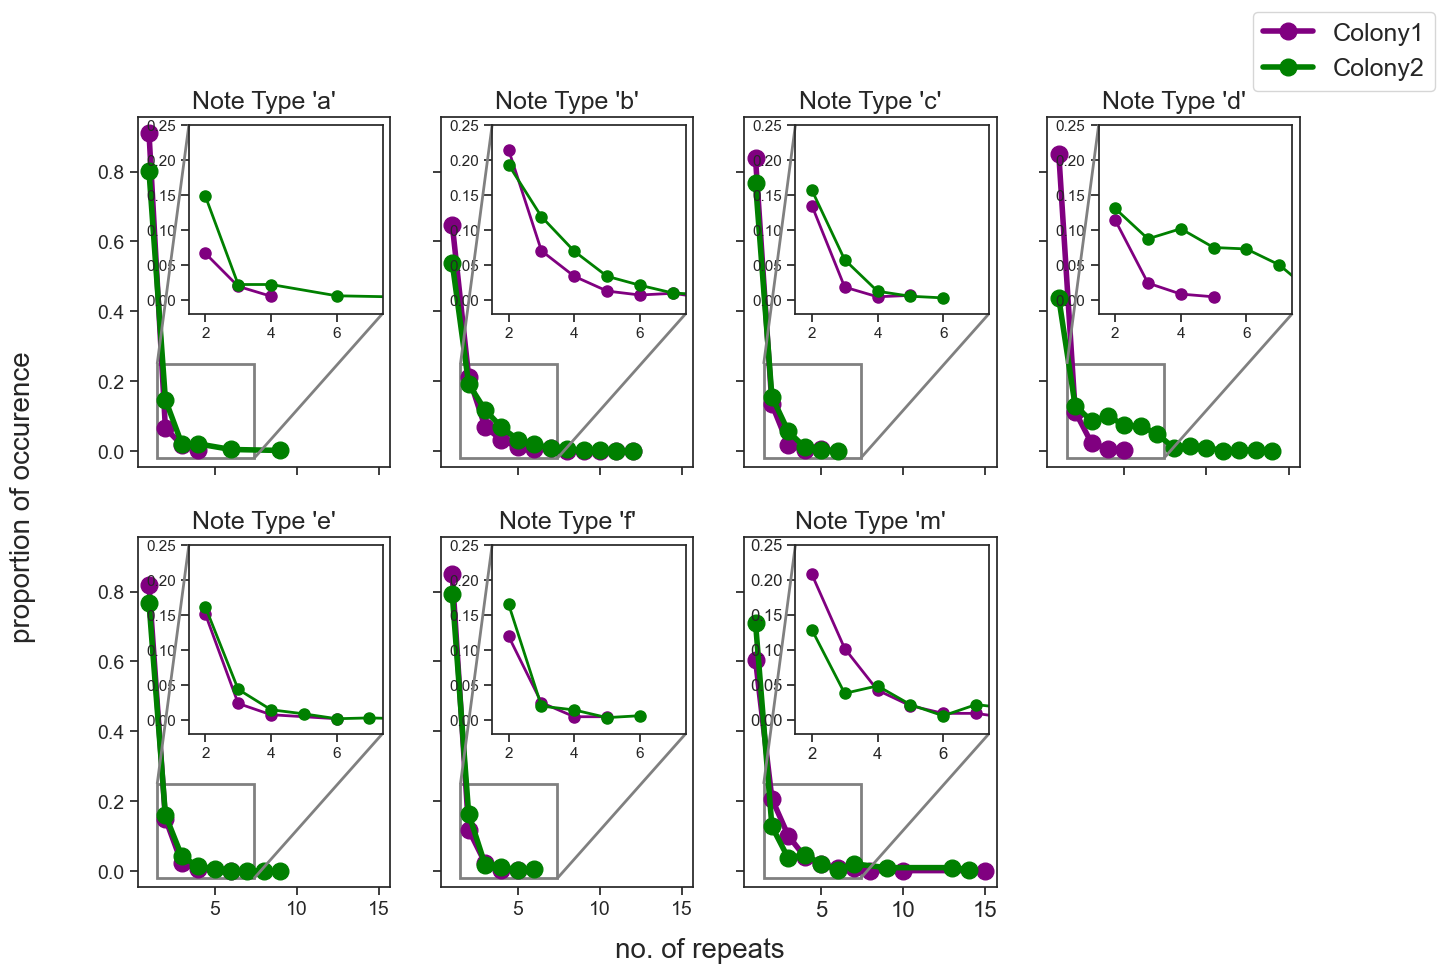

In [71]:
# plotting freq of repeats plot

labels=["Colony1", "Colony2"]
fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(15, 10))
sns.set_theme(style='ticks')


fig.text(0.5, 0.04, 'no. of repeats', ha='center', size=20)
fig.text(0.04, 0.5, 'proportion of occurence', va='center', rotation='vertical', size=20)

ax1=plt.subplot(2,4,1)
l1=ax1.plot(prop1a,marker="o",linewidth=4, color="purple", markersize=12)
l2=ax1.plot(prop2a, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'a'", size=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

axins = zoomed_inset_axes(ax1,2, loc="upper right")
axins.plot(prop1a_n, marker="o", linewidth=2, color="purple", markersize=8)
axins.plot(prop2a_n, marker="o", linewidth=2, color="green", markersize=8)

axins.set_xlim(1.5, 7.4)
axins.set_ylim(-0.02, 0.25)
plt.setp(axins.get_xticklabels(), visible=True)
plt.setp(axins.get_yticklabels(), visible=True)
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", lw=2, ec='0.5')


ax1=plt.subplot(2,4,2)
l1=ax1.plot(prop1b,marker="o",linewidth=4, color="purple", markersize=12)
l2=ax1.plot(prop2b, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'b'", size=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

axins = zoomed_inset_axes(ax1,2, loc="upper right")
axins.plot(prop1b_n, marker="o", linewidth=2, color="purple", markersize=8)
axins.plot(prop2b_n, marker="o", linewidth=2, color="green", markersize=8)

axins.set_xlim(1.5, 7.4)
axins.set_ylim(-0.02, 0.25)
plt.setp(axins.get_xticklabels(), visible=True)
plt.setp(axins.get_yticklabels(), visible=True)
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", lw=2, ec='0.5')

ax1=plt.subplot(2,4,3)
l1=ax1.plot(prop1c,marker="o",linewidth=4, color="purple", markersize=12)
l2=ax1.plot(prop2c, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'c'", size=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

axins = zoomed_inset_axes(ax1,2, loc="upper right")
axins.plot(prop1c_n, marker="o", linewidth=2, color="purple", markersize=8)
axins.plot(prop2c_n, marker="o", linewidth=2, color="green", markersize=8)

axins.set_xlim(1.5, 7.4)
axins.set_ylim(-0.02, 0.25)
plt.setp(axins.get_xticklabels(), visible=True)
plt.setp(axins.get_yticklabels(), visible=True)
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", lw=2, ec='0.5')

ax1=plt.subplot(2,4,4)
l1=ax1.plot(prop1d,marker="o",linewidth=4, color="purple", markersize=12)
l2=ax1.plot(prop2d, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'd'", size=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
axins = zoomed_inset_axes(ax1,2, loc="upper right")
axins.plot(prop1d_n, marker="o", linewidth=2, color="purple", markersize=8)
axins.plot(prop2d_n, marker="o", linewidth=2, color="green", markersize=8)

axins.set_xlim(1.5, 7.4)
axins.set_ylim(-0.02, 0.25)
plt.setp(axins.get_xticklabels(), visible=True)
plt.setp(axins.get_yticklabels(), visible=True)
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", lw=2, ec='0.5')

ax1=plt.subplot(2,4,5)
l1=ax1.plot(prop1e,marker="o",linewidth=4, color="purple", markersize=12)
l2=ax1.plot(prop2e, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'e'", size=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

axins = zoomed_inset_axes(ax1,2, loc="upper right")
axins.plot(prop1e_n, marker="o", linewidth=2, color="purple", markersize=8)
axins.plot(prop2e_n, marker="o", linewidth=2, color="green", markersize=8)

axins.set_xlim(1.5, 7.4)
axins.set_ylim(-0.02, 0.25)
plt.setp(axins.get_xticklabels(), visible=True)
plt.setp(axins.get_yticklabels(), visible=True)
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", lw=2, ec='0.5')

ax1=plt.subplot(2,4,6)
l1=ax1.plot(prop1f,marker="o",linewidth=4, color="purple", markersize=12)
l2=ax1.plot(prop2f, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'f'", size=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

axins = zoomed_inset_axes(ax1,2, loc="upper right")
axins.plot(prop1f_n, marker="o", linewidth=2, color="purple", markersize=8)
axins.plot(prop2f_n, marker="o", linewidth=2, color="green", markersize=8)

axins.set_xlim(1.5, 7.4)
axins.set_ylim(-0.02, 0.25)
plt.setp(axins.get_xticklabels(), visible=True)
plt.setp(axins.get_yticklabels(), visible=True)
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", lw=2, ec='0.5')

ax1=plt.subplot(2,4,7)
l1=ax1.plot(prop1m,marker="o",linewidth=4, color="purple", markersize=12)
l2=ax1.plot(prop2m, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'm'", size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

axins = zoomed_inset_axes(ax1,2, loc="upper right")
axins.plot(prop1m_n, marker="o", linewidth=2, color="purple", markersize=8)
axins.plot(prop2m_n, marker="o", linewidth=2, color="green", markersize=8)

axins.set_xlim(1.5, 7.4)
axins.set_ylim(-0.02, 0.25)
plt.setp(axins.get_xticklabels(), visible=True, fontsize=12)
plt.setp(axins.get_yticklabels(), visible=True, fontsize=12)

mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", lw=2, ec='0.5')

ax_n=plt.subplot(2,4,8)
fig.delaxes(ax=ax_n)


fig.legend([l1, l2], labels=labels,
           loc="upper right", fontsize=18)

plt.savefig("figures/Freq. of repeats_before_v3.svg", dpi=500, bbox_inches='tight')

In [373]:
prop1a.drop(index=prop1a.index[0], 
        axis=0, 
        inplace=True)
prop1b.drop(index=prop1b.index[0], 
        axis=0, 
        inplace=True)
prop1c.drop(index=prop1c.index[0], 
        axis=0, 
        inplace=True)
prop1d.drop(index=prop1d.index[0], 
        axis=0, 
        inplace=True)
prop1e.drop(index=prop1e.index[0], 
        axis=0, 
        inplace=True)
prop1f.drop(index=prop1f.index[0], 
        axis=0, 
        inplace=True)
prop1m.drop(index=prop1m.index[0], 
        axis=0, 
        inplace=True)


prop2a.drop(index=prop2a.index[0], 
        axis=0, 
        inplace=True)
prop2b.drop(index=prop2b.index[0], 
        axis=0, 
        inplace=True)
prop2c.drop(index=prop2c.index[0], 
        axis=0, 
        inplace=True)
prop2d.drop(index=prop2d.index[0], 
        axis=0, 
        inplace=True)
prop2e.drop(index=prop2e.index[0], 
        axis=0, 
        inplace=True)
prop2f.drop(index=prop2f.index[0], 
        axis=0, 
        inplace=True)
prop2m.drop(index=prop2m.index[0], 
        axis=0, 
        inplace=True)


In [68]:
prop1a_n=prop1a.iloc[1: , :]
prop1b_n=prop1b.iloc[1: , :]
prop1c_n=prop1c.iloc[1: , :]
prop1d_n=prop1d.iloc[1: , :]
prop1e_n=prop1e.iloc[1: , :]
prop1f_n=prop1f.iloc[1: , :]
prop1m_n=prop1m.iloc[1: , :]


prop2a_n=prop2a.iloc[1: , :]
prop2b_n=prop2b.iloc[1: , :]
prop2c_n=prop2c.iloc[1: , :]
prop2d_n=prop2d.iloc[1: , :]
prop2e_n=prop2e.iloc[1: , :]
prop2f_n=prop2f.iloc[1: , :]
prop2m_n=prop2m.iloc[1: , :]


In [53]:
prop2m_n

,0
2.0,0.128342
3.0,0.037433
4.0,0.048128
5.0,0.021390
6.0,0.005348
7.0,0.021390
9.0,0.010695
13.0,0.010695
14.0,0.005348


C:\Users\ANANDK~1\AppData\Local\Temp/ipykernel_16992/1236064865.py:43: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=labels,


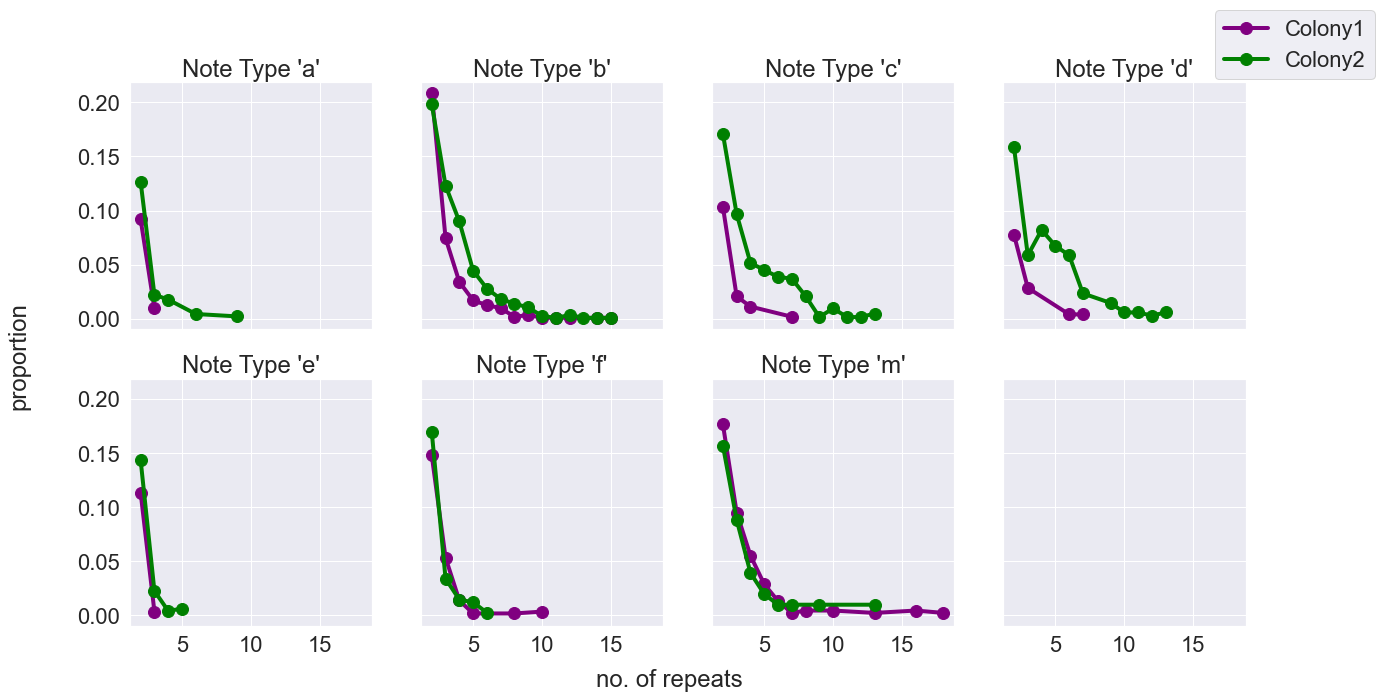

In [375]:
labels=["Colony1", "Colony2"]
fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(20, 10))

fig.text(0.5, 0.04, 'no. of repeats', ha='center')
fig.text(0.04, 0.5, 'proportion', va='center', rotation='vertical')

plt.subplot(2,4,1)
l1=plt.plot(prop1a,marker="o",linewidth=4, color="purple", markersize=12)
l2=plt.plot(prop2a, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'a'")

plt.subplot(2,4,2)
plt.plot(prop1b,marker="o",linewidth=4, color="purple", markersize=12)
plt.plot(prop2b, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'b'")

plt.subplot(2,4,3)
plt.plot(prop1c,marker="o",linewidth=4, color="purple", markersize=12)
plt.plot(prop2c, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'c'")

plt.subplot(2,4,4)
plt.plot(prop1d,marker="o",linewidth=4, color="purple", markersize=12)
plt.plot(prop2d, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'd'")

plt.subplot(2,4,5)
plt.plot(prop1e,marker="o",linewidth=4, color="purple", markersize=12)
plt.plot(prop2e, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'e'")

plt.subplot(2,4,6)
plt.plot(prop1f,marker="o",linewidth=4, color="purple", markersize=12)
plt.plot(prop2f, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'f'")

plt.subplot(2,4,7)
plt.plot(prop1m,marker="o",linewidth=4, color="purple", markersize=12)
plt.plot(prop2m, marker="o", linewidth=4, color="green", markersize=12)
plt.title("Note Type 'm'")


fig.legend([l1, l2], labels=labels,
           loc="upper right")

In [258]:
prop2d

1.0     0.516129
2.0     0.158358
4.0     0.082111
5.0     0.067449
6.0     0.058651
3.0     0.058651
7.0     0.023460
9.0     0.014663
10.0    0.005865
13.0    0.005865
11.0    0.005865
12.0    0.002933
Name: d, dtype: float64

<AxesSubplot:xlabel='m', ylabel='Probability'>

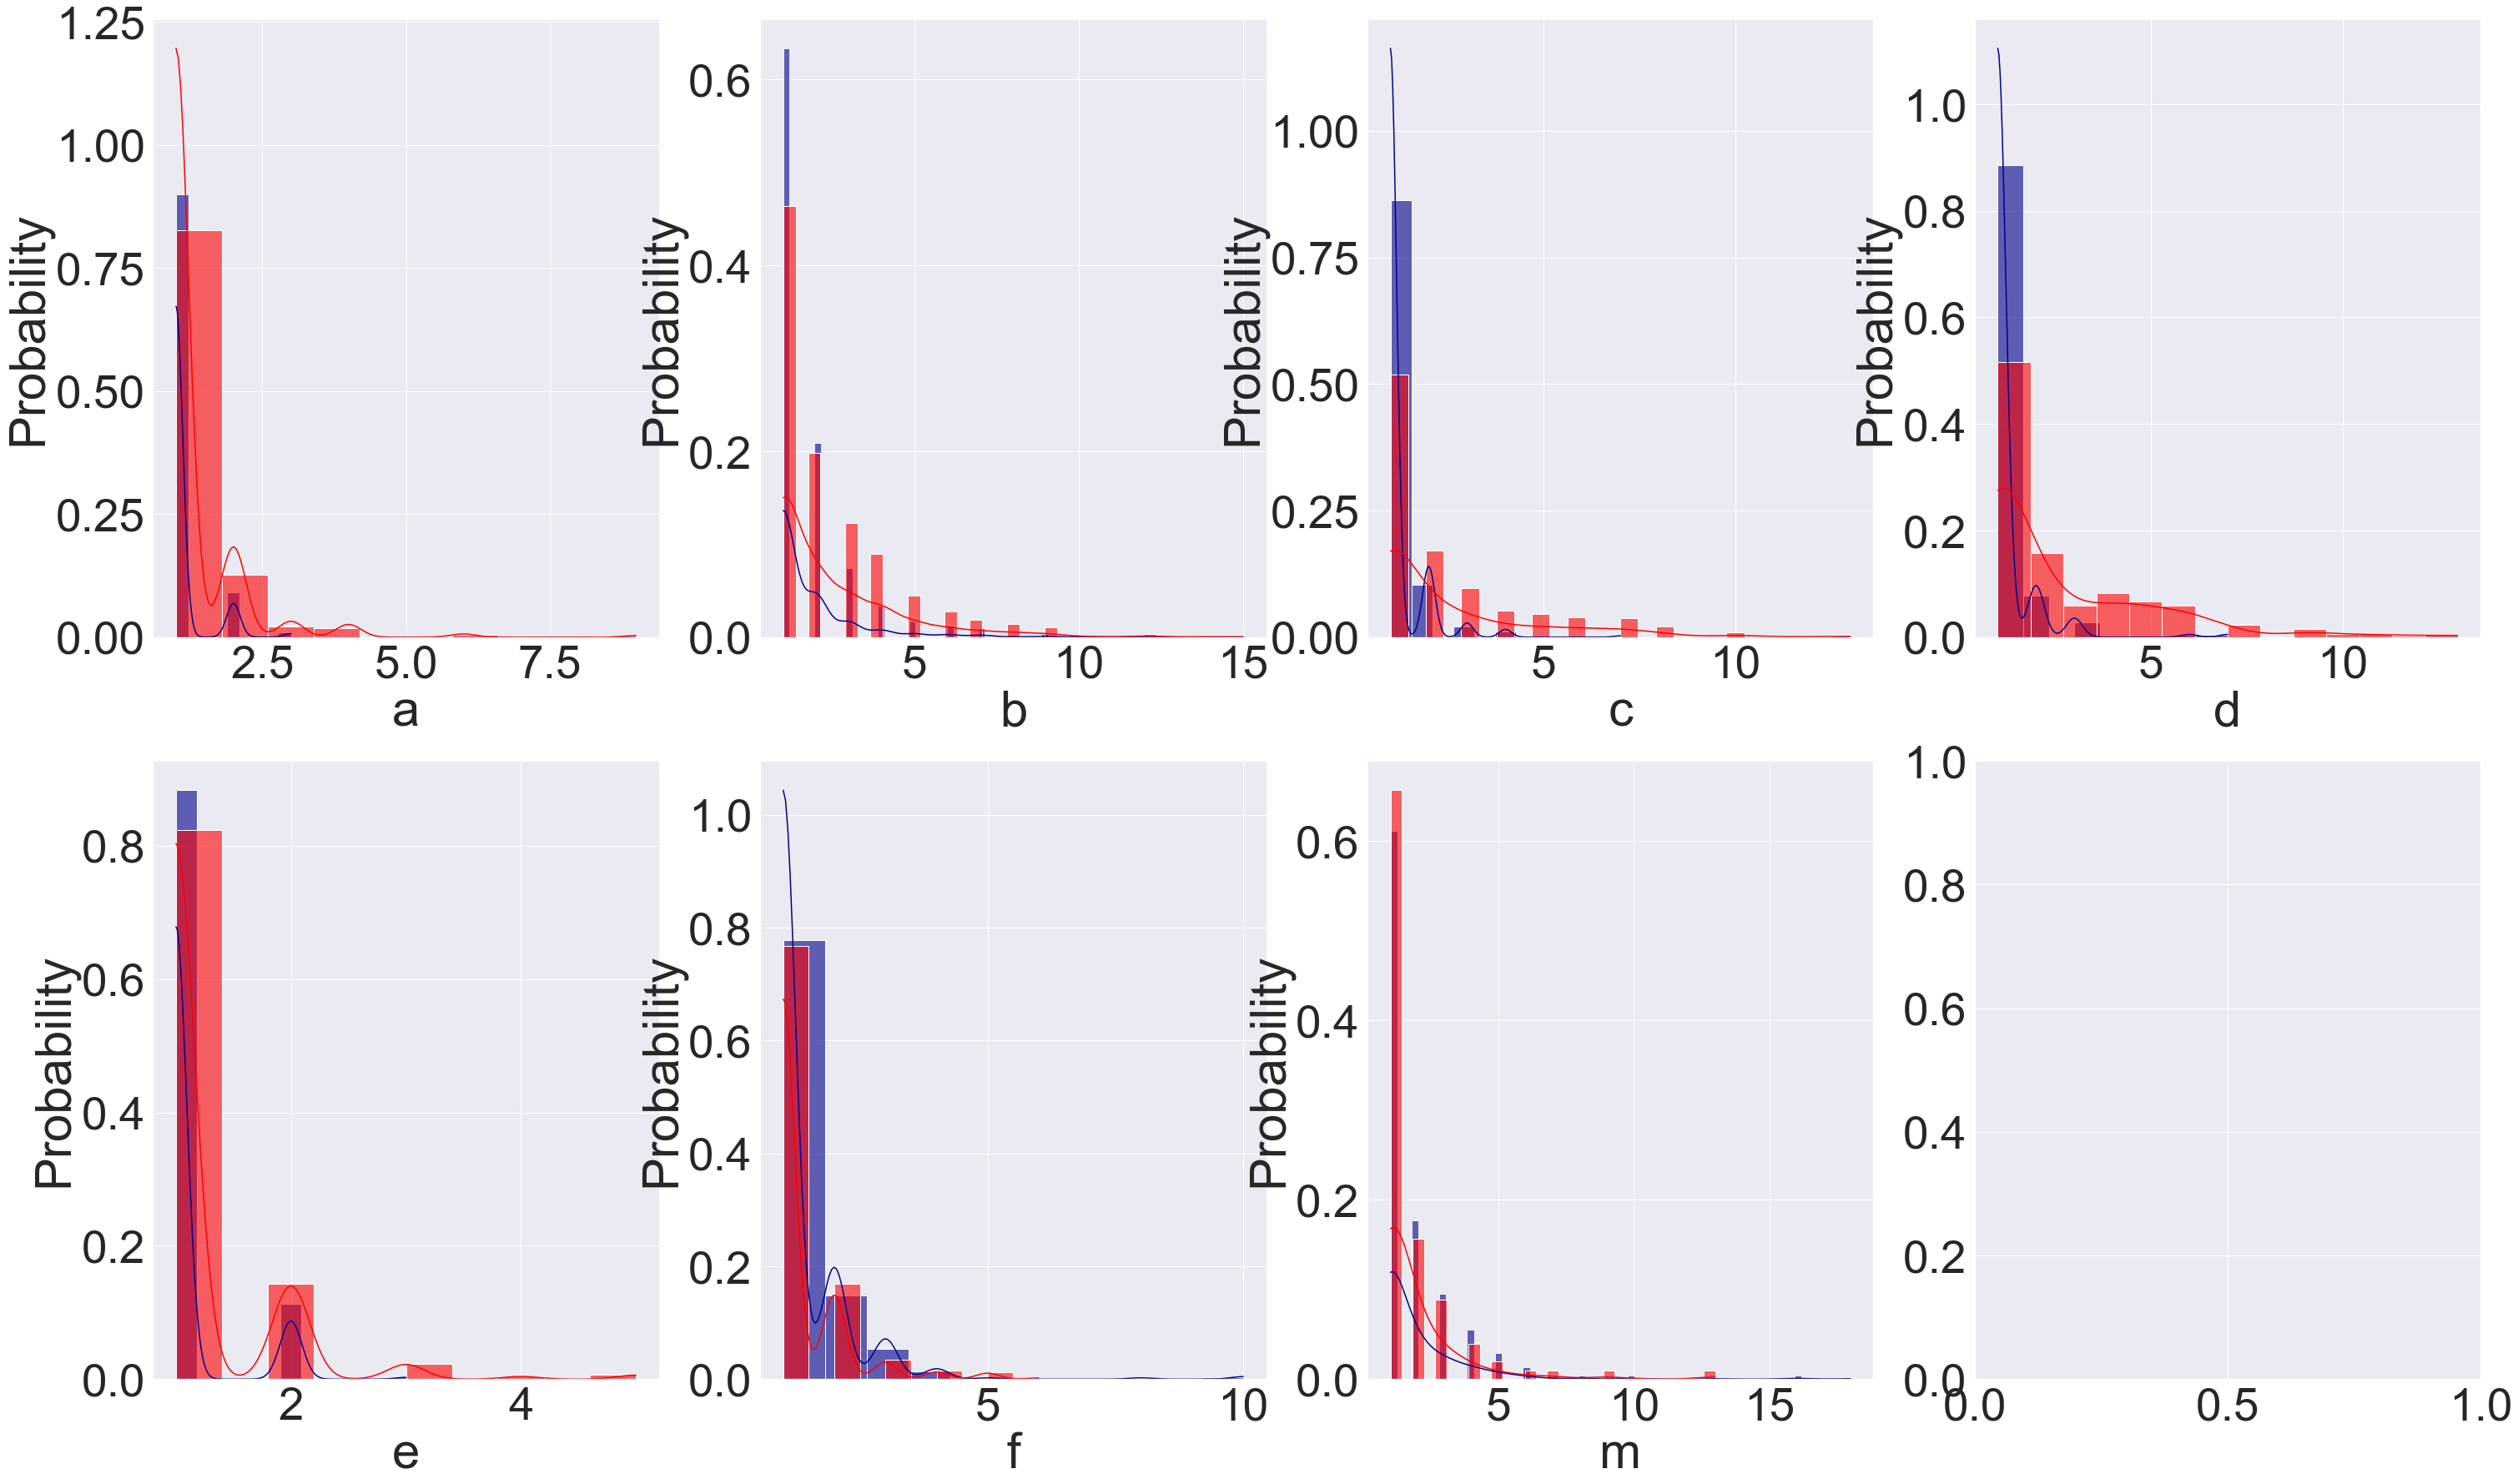

In [161]:
## frequency histogram plots for repeat
plt.subplots(2,4,figsize=(50,30))
sns.set(style="darkgrid",font_scale=5)
legend=["Colony1", "Colony2"]
plt.subplot(2,4,1)
ax1=sns.histplot(data=rep_freq1['a'], color="darkblue", kde=True,alpha=0.6, stat='probability')
ax1=sns.histplot(data=rep_freq2['a'] , color="red", kde=True,alpha=0.6, stat='probability')

plt.subplot(2,4,2)
sns.histplot(data=rep_freq1['b'], color="darkblue", label="Colony 1", kde=True,alpha=0.6, stat='probability')
sns.histplot(data=rep_freq2['b'] , color="red", label="Colony 2", kde=True,alpha=0.6, stat='probability')

plt.subplot(2,4,3)
sns.histplot(data=rep_freq1['c'], color="darkblue", label="Colony 1", kde=True,alpha=0.6, stat='probability')
sns.histplot(data=rep_freq2['c'] , color="red", label="Colony 2", kde=True,alpha=0.6, stat='probability')

plt.subplot(2,4,4)
sns.histplot(data=rep_freq1['d'], color="darkblue", label="Colony 1", kde=True,alpha=0.6 ,stat='probability')
sns.histplot(data=rep_freq2['d'] , color="red", label="Colony 2", kde=True,alpha=0.6, stat='probability')

plt.subplot(2,4,5)
sns.histplot(data=rep_freq1['e'], color="darkblue", label="Colony 1", kde=True,alpha=0.6, stat='probability')
sns.histplot(data=rep_freq2['e'] , color="red", label="Colony 2", kde=True,alpha=0.6, stat='probability')

plt.subplot(2,4,6)
sns.histplot(data=rep_freq1['f'], color="darkblue", label="Colony 1", kde=True,alpha=0.6, stat='probability')
sns.histplot(data=rep_freq2['f'] , color="red", label="Colony 2", kde=True,alpha=0.6, stat='probability')

plt.subplot(2,4,7)
sns.histplot(data=rep_freq1['m'], color="darkblue", label="Colony 1", kde=True,alpha=0.6, stat='probability')
sns.histplot(data=rep_freq2['m'] , color="red", label="Colony 2", kde=True,alpha=0.6, stat='probability')

In [30]:
dat_ind=dat.groupby(dat['ind'])
dat_ind11=dat_ind.get_group(11)
dat_ind12=dat_ind.get_group(12)
dat_ind11=dat_ind11.reset_index()
dat_ind12=dat_ind12.reset_index()

dat_ind21=dat_ind.get_group(21)
dat_ind22=dat_ind.get_group(22)
dat_ind23=dat_ind.get_group(22)
dat_ind21=dat_ind21.reset_index()
dat_ind22=dat_ind22.reset_index()
dat_ind23=dat_ind23.reset_index()

In [31]:
rep_freq11=freq_rep(dat_ind11)
rep_freq12=freq_rep(dat_ind12)
rep_freq21=freq_rep(dat_ind21)
rep_freq22=freq_rep(dat_ind22)
rep_freq23=freq_rep(dat_ind23)


In [32]:
rep11a=pd.Series(sorted(rep_freq11['a']))
freq11a=rep11a.value_counts().sort_index(0)
rep11b=pd.Series(sorted(rep_freq11['b']))
freq11b=rep11b.value_counts().sort_index(0)
rep11c=pd.Series(sorted(rep_freq11['c']))
freq11c=rep11c.value_counts().sort_index(0)
rep11d=pd.Series(sorted(rep_freq11['d']))
freq11d=rep11d.value_counts().sort_index(0)
rep11e=pd.Series(sorted(rep_freq11['e']))
freq11e=rep11e.value_counts().sort_index(0)
rep11f=pd.Series(sorted(rep_freq11['f']))
freq11f=rep11f.value_counts().sort_index(0)
rep11m=pd.Series(sorted(rep_freq11['m']))
freq11m=rep11m.value_counts().sort_index(0)

rep12a=pd.Series(sorted(rep_freq12['a']))
freq12a=rep12a.value_counts().sort_index(0)
rep12b=pd.Series(sorted(rep_freq12['b']))
freq12b=rep12b.value_counts().sort_index(0)
rep12c=pd.Series(sorted(rep_freq12['c']))
freq12c=rep12c.value_counts().sort_index(0)
rep12d=pd.Series(sorted(rep_freq12['d']))
freq12d=rep12d.value_counts().sort_index(0)
rep12e=pd.Series(sorted(rep_freq12['e']))
freq12e=rep12e.value_counts().sort_index(0)
rep12f=pd.Series(sorted(rep_freq12['f']))
freq12f=rep12f.value_counts().sort_index(0)
rep12m=pd.Series(sorted(rep_freq12['m']))
freq12m=rep12m.value_counts().sort_index(0)

rep21a=pd.Series(sorted(rep_freq21['a']))
freq21a=rep21a.value_counts().sort_index(0)
rep21b=pd.Series(sorted(rep_freq21['b']))
freq21b=rep21b.value_counts().sort_index(0)
rep21c=pd.Series(sorted(rep_freq21['c']))
freq21c=rep21c.value_counts().sort_index(0)
rep21d=pd.Series(sorted(rep_freq21['d']))
freq21d=rep21d.value_counts().sort_index(0)
rep21e=pd.Series(sorted(rep_freq21['e']))
freq21e=rep21e.value_counts().sort_index(0)
rep21f=pd.Series(sorted(rep_freq21['f']))
freq21f=rep21f.value_counts().sort_index(0)
rep21m=pd.Series(sorted(rep_freq21['m']))
freq21m=rep21m.value_counts().sort_index(0)

rep22a=pd.Series(sorted(rep_freq22['a']))
freq22a=rep22a.value_counts().sort_index(0)
rep22b=pd.Series(sorted(rep_freq22['b']))
freq22b=rep22b.value_counts().sort_index(0)
rep22c=pd.Series(sorted(rep_freq22['c']))
freq22c=rep22c.value_counts().sort_index(0)
rep22d=pd.Series(sorted(rep_freq22['d']))
freq22d=rep22d.value_counts().sort_index(0)
rep22e=pd.Series(sorted(rep_freq22['e']))
freq22e=rep22e.value_counts().sort_index(0)
rep22f=pd.Series(sorted(rep_freq22['f']))
freq22f=rep22f.value_counts().sort_index(0)
rep22m=pd.Series(sorted(rep_freq22['m']))
freq22m=rep12m.value_counts().sort_index(0)

rep23a=pd.Series(sorted(rep_freq23['a']))
freq23a=rep23a.value_counts().sort_index(0)
rep23b=pd.Series(sorted(rep_freq23['b']))
freq23b=rep23b.value_counts().sort_index(0)
rep23c=pd.Series(sorted(rep_freq23['c']))
freq23c=rep23c.value_counts().sort_index(0)
rep23d=pd.Series(sorted(rep_freq23['d']))
freq23d=rep23d.value_counts().sort_index(0)
rep23e=pd.Series(sorted(rep_freq23['e']))
freq23e=rep23e.value_counts().sort_index(0)
rep23f=pd.Series(sorted(rep_freq23['f']))
freq23f=rep23f.value_counts().sort_index(0)
rep23m=pd.Series(sorted(rep_freq23['m']))
freq23m=rep23m.value_counts().sort_index(0)



/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_1718/1575191068.py:2: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  freq11a=rep11a.value_counts().sort_index(0)
/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_1718/1575191068.py:4: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  freq11b=rep11b.value_counts().sort_index(0)
/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_1718/1575191068.py:6: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  freq11c=rep11c.value_counts().sort_index(0)
/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_1718/1575191068.py:8: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  freq11d=rep11d.value_counts().sort_index(0)
/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_1718/1575191068.py:10: Fu

In [33]:
prop11a=pd.DataFrame(freq11a/sum(freq11a))
prop11b=pd.DataFrame(freq11b/sum(freq11b))
prop11c=pd.DataFrame(freq11c/sum(freq11c))
prop11d=pd.DataFrame(freq11d/sum(freq11d))
prop11e=pd.DataFrame(freq11e/sum(freq11e))
prop11f=pd.DataFrame(freq11f/sum(freq11f))
prop11m=pd.DataFrame(freq11m/sum(freq11m))

prop12a=pd.DataFrame(freq12a/sum(freq12a))
prop12b=pd.DataFrame(freq12b/sum(freq12b))
prop12c=pd.DataFrame(freq12c/sum(freq12c))
prop12d=pd.DataFrame(freq12d/sum(freq12d))
prop12e=pd.DataFrame(freq12e/sum(freq12e))
prop12f=pd.DataFrame(freq12f/sum(freq12f))
prop12m=pd.DataFrame(freq12m/sum(freq12m))

prop21a=pd.DataFrame(freq21a/sum(freq21a))
prop21b=pd.DataFrame(freq21b/sum(freq21b))
prop21c=pd.DataFrame(freq21c/sum(freq21c))
prop21d=pd.DataFrame(freq21d/sum(freq21d))
prop21e=pd.DataFrame(freq21e/sum(freq21e))
prop21f=pd.DataFrame(freq21f/sum(freq21f))
prop21m=pd.DataFrame(freq21m/sum(freq21m))

prop22a=pd.DataFrame(freq22a/sum(freq22a))
prop22b=pd.DataFrame(freq22b/sum(freq22b))
prop22c=pd.DataFrame(freq22c/sum(freq22c))
prop22d=pd.DataFrame(freq22d/sum(freq22d))
prop22e=pd.DataFrame(freq22e/sum(freq22e))
prop22f=pd.DataFrame(freq22f/sum(freq22f))
prop22m=pd.DataFrame(freq22m/sum(freq22m))

prop23a=pd.DataFrame(freq23a/sum(freq23a))
prop23b=pd.DataFrame(freq23b/sum(freq23b))
prop23c=pd.DataFrame(freq23c/sum(freq23c))
prop23d=pd.DataFrame(freq23d/sum(freq23d))
prop23e=pd.DataFrame(freq23e/sum(freq23e))
prop23f=pd.DataFrame(freq23f/sum(freq23f))
prop23m=pd.DataFrame(freq23m/sum(freq23m))

/var/folders/x_/lknyn55s7v37wq_nskg6x7pr0000gn/T/ipykernel_1718/1302305972.py:89: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1,l2,l3,l4,l5], labels=labels,


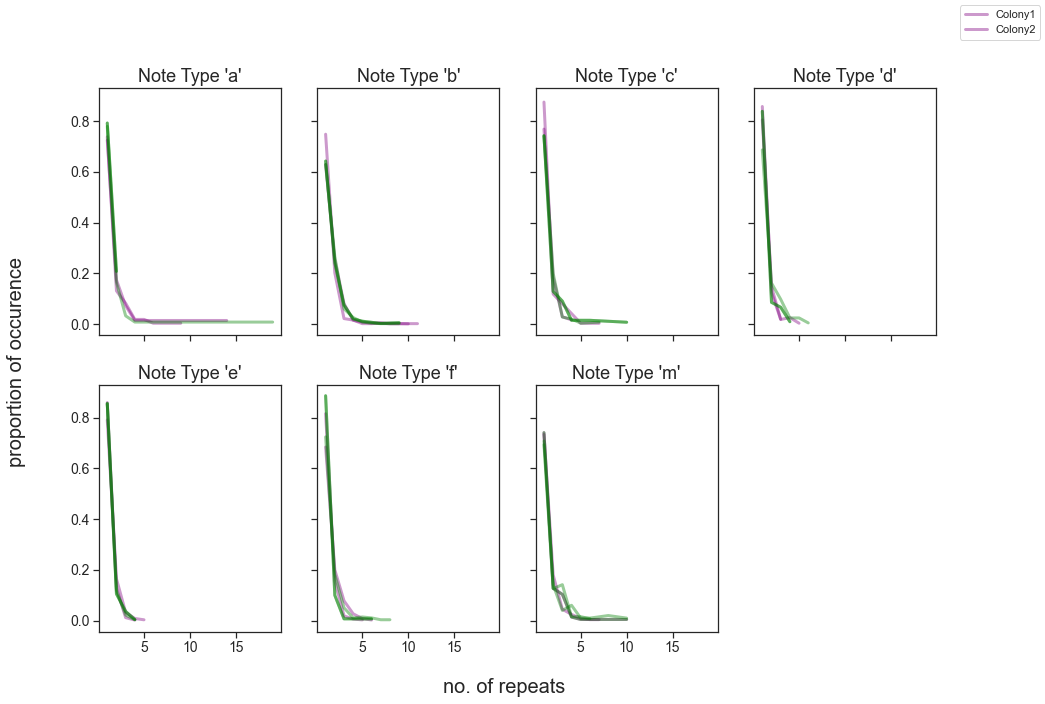

In [36]:
labels=["Colony1", "Colony2"]
fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(15, 10))
sns.set_theme(style='ticks')
fig.text(0.5, 0.04, 'no. of repeats', ha='center', size=20)
fig.text(0.04, 0.5, 'proportion of occurence', va='center', rotation='vertical', size=20)

plt.subplot(2,4,1)
l1=plt.plot(prop11a,linewidth=3, color="purple",alpha=0.4)
l2=plt.plot(prop12a, linewidth=3, color="purple", alpha=0.4)
l3=plt.plot(prop21a,linewidth=3, color="green", alpha=0.4)
l4=plt.plot(prop22a, linewidth=3, color="green", alpha=0.4)
l5=plt.plot(prop23a,linewidth=3, color="green", alpha=0.4)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title("Note Type 'a'",size=18)

plt.subplot(2,4,2)
l1=plt.plot(prop11b,linewidth=3, color="purple",alpha=0.4)
l2=plt.plot(prop12b, linewidth=3, color="purple", alpha=0.4)
l3=plt.plot(prop21b,linewidth=3, color="green", alpha=0.4)
l4=plt.plot(prop22b, linewidth=3, color="green", alpha=0.4)
l5=plt.plot(prop23b,linewidth=3, color="green", alpha=0.4)
plt.title("Note Type 'b'",size=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(2,4,3)
l1=plt.plot(prop11c,linewidth=3, color="purple",alpha=0.4)
l2=plt.plot(prop12c, linewidth=3, color="purple", alpha=0.4)
l3=plt.plot(prop21c,linewidth=3, color="green", alpha=0.4)
l4=plt.plot(prop22c, linewidth=3, color="green", alpha=0.4)
l5=plt.plot(prop23c,linewidth=3, color="green", alpha=0.4)
plt.title("Note Type 'c'",size=18)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(2,4,4)
l1=plt.plot(prop11d,linewidth=3, color="purple",alpha=0.4)
l2=plt.plot(prop12d, linewidth=3, color="purple", alpha=0.4)
l3=plt.plot(prop21d,linewidth=3, color="green", alpha=0.4)
l4=plt.plot(prop22d, linewidth=3, color="green", alpha=0.4)
l5=plt.plot(prop23d,linewidth=3, color="green", alpha=0.4)
plt.title("Note Type 'd'", size=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(2,4,5)
l1=plt.plot(prop11e,linewidth=3, color="purple",alpha=0.4)
l2=plt.plot(prop12e, linewidth=3, color="purple", alpha=0.4)
l3=plt.plot(prop21e,linewidth=3, color="green", alpha=0.4)
l4=plt.plot(prop22e, linewidth=3, color="green", alpha=0.4)
l5=plt.plot(prop23e,linewidth=3, color="green", alpha=0.4)
plt.title("Note Type 'e'", size=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(2,4,6)
l1=plt.plot(prop11f,linewidth=3, color="purple",alpha=0.4)
l2=plt.plot(prop12f, linewidth=3, color="purple", alpha=0.4)
l3=plt.plot(prop21f,linewidth=3, color="green", alpha=0.4)
l4=plt.plot(prop22f, linewidth=3, color="green", alpha=0.4)
l5=plt.plot(prop23f,linewidth=3, color="green", alpha=0.4)
plt.title("Note Type 'f'", size=18)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(2,4,7)
l1=plt.plot(prop11m,linewidth=3, color="purple",alpha=0.4)
l2=plt.plot(prop12m, linewidth=3, color="purple", alpha=0.4)
l3=plt.plot(prop21m,linewidth=3, color="green", alpha=0.4)
l4=plt.plot(prop22m, linewidth=3, color="green", alpha=0.4)
l5=plt.plot(prop23m,linewidth=3, color="green", alpha=0.4)
plt.title("Note Type 'm'", size=18)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


fig.legend([l1,l2,l3,l4,l5], labels=labels,
           loc="upper right")
ax_n=plt.subplot(2,4,8)
fig.delaxes(ax=ax_n)
plt.savefig("figures/ind_freq_repeats_after.svg", dpi=500, bbox_inches='tight')

In [78]:
dat_ind21['Shannon Entropy']

0     1.113392
1     1.685928
2     1.365758
3     1.306571
4     1.455997
5     1.386398
6     1.242580
7     1.144523
8     1.507608
9     1.368925
10    1.752716
11    1.685125
12    1.738053
13    1.581363
14    1.626650
15    1.622118
16    1.526616
17    1.852611
18    1.673118
19    1.622314
Name: Shannon Entropy, dtype: float64

In [18]:
%history -g

 2/1:

# importing the modules
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors
 2/2:
dat=pd.read_csv('KL divergence.csv')
heatmap=sns.heatmap(data=dat)
 2/3:

# importing the modules
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors
 2/4:
dat=pd.read_csv('KL divergence.csv')
heatmap=sns.heatmap(data=dat)
plt.show()
 2/5:
dat=pd.read_csv('KL divergence.csv')
heatmap=sn.heatmap(data=dat)
plt.show()
 2/6:
dat=pd.read_csv('KL divergence.csv',header=0, index_col=0)
heatmap=sn.heatmap(data=dat)
plt.show()
 2/7:
dat=pd.read_csv('KL divergence.csv',header=0, index_col=0)
dat=pd.Dataframe(dat)
mask=dat.isnull()
dat=dat()
heatmap=sn.heatmap(data=dat, mask=mask)
plt.show()
 2/8:
dat=pd.read_csv('KL divergence.csv',header=0, index_col=0)
dat=pd.DataFrame(dat)
mask=dat.isnull()
dat=dat()
heatmap=sn.heatmap(data=dat, mask=mask)
plt.show()
 2/9:
d

21/30:
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
fig=plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
ax1=sns.boxplot(x='Cage',y='Shannon Entropy', data=dat_dur_mean)
plt.title("")
plt.ylim([0,2.5])
#plt.subplot(1,2,2)
#ax2=sns.boxplot(x='Context', y='Shannon Entropy', data=dat_colony2)
#plt.title("Colony 2")
#plt.ylim([0,2.5])
21/31:
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
fig=plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
ax1=sns.boxplot(x='Cage',y='Shannon Entropy', data=dat_dur_mean)
ax2=sns.catplot(x="Cage", y="Shannon Entropy", kind="swarm", data=dat_dur_mean)
plt.title("")
plt.ylim([0,2.5])
#plt.subplot(1,2,2)
#ax2=sns.boxplot(x='Context', y='Shannon Entropy', data=dat_colony2)
#plt.title("Colony 2")
#plt.ylim([0,2.5])
21/32:
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
fig=plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
ax1=sns.boxplot(x='Cage',y='Shannon Entropy', data=dat_dur_mean)
sns.catplot(x="Cage", y="Shannon Entropy", kind="swarm", data=d

26/68: dat_ind21['Shannon Entropy']
26/69: dat_ind21
26/70:
dat=pd.read_csv('D://Abhinav/budgerigar project/Budgerigar Project - warble sequence data.csv',header=0)

dat=pd.DataFrame(dat)

## Calculating shannon entropy
H=shannon_entropy(dat, base=None)
dat['Shannon Entropy']=H
## Context-based grouping
dat_contextseq=dat.groupby(dat['Context'])
dat_maleseq=dat_contextseq.get_group(1)
dat_maleseq=dat_maleseq.reset_index()
dat_femaleseq=dat_contextseq.get_group(2)
dat_femaleseq=dat_femaleseq.reset_index()
## Colony-based grouping
dat_colonyseq=dat.groupby(dat['Cage'])
dat_colony1=dat_colonyseq.get_group(1)
dat_colony2=dat_colonyseq.get_group(2)
dat_colony1=dat_colony1.reset_index()
dat_colony2=dat_colony2.reset_index()

#dat_combined=pd.DataFrame({dat_maleseq,dat_femaleseq,dat_colony1,dat_colony2})
26/71:
dat=pd.read_csv('D://Abhinav/budgerigar project/Budgerigar Project - warble sequence data.csv',header=0)

dat=pd.DataFrame(dat)

## Calculating shannon entropy
H=shannon_entropy(dat, b

28/44:
# Box plot for Shannon Entropy
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)
fig=plt.figure(figsize=(15,12))
plt.subplot(1,2,1)
ax1=sns.boxplot(x='Cage',y='Duration (s)', hue="Context" , data=dat, palette="colorblind")
new_legend=['Male-Male',"Male-Female"]
ax1.legend_.texts[0].set_text(new_legend[0])
ax1.legend_.texts[1].set_text(new_legend[1])
#fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#fig.legend_.texts[0].set_text(new_legend[0])
#fig.legend_.texts[1].set_text(new_legend[1])
ax1.set_xlabel("Colony")
plt.title("Duration (s) of Warble")

plt.subplot(1,2,2)
ax2=sns.boxplot(x='Cage', y='Shannon Entropy', hue="Context",data=dat,palette="colorblind")
plt.title("Shannon Entropy (H) of Warble")
ax2.set_ylim([0.5,2.5])
ax2.legend_.texts[0].set_text(new_legend[0])
ax2.legend_.texts[1].set_text(new_legend[1])
ax2.set_xlabel("Colony")


#plt.savefig("figures/Box-Plot.svg", dpi=500, bbox_inches="tight")
28/45:
# Box plot for Shannon Entropy
sns.set_theme(style=

In [36]:
def bootstrep(df):
    

,Pair No,Date,Context,Cage,ind,Sample ID,seq length,Warble No,Duration (s),note sequence,...,Unnamed: 787,Unnamed: 788,Unnamed: 789,Unnamed: 790,Unnamed: 791,Unnamed: 792,Unnamed: 793,Unnamed: 794,Unnamed: 795,Shannon Entropy
23,10,NaN,1,2,100,19700117_031612-19700117_032745,131,4,32.0351,b0bbaeba0bbeeddddddabbccbceeccccccaffefbefbbbb...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.679450
121,5,NaN,2,1,12,19700103_013452-19700103_015037,58,2,20.2591,dfdfb0befm0emmfbmbmmmmbemcfmmbebmmmmbcbebmmbbb...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.649966
136,7,NaN,2,1,12,19700115_201245-19700115_202637,49,7,14.3185,bmcbe0beebcfmffbabbebb0ebcbbecfbedcmfbmmmmmabfeff,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.823512
28,10,NaN,1,2,100,19700117_224720-1970017_230320,123,9,27.4117,babbbeacccccdeedba0ddbbcccccbccccbaccccccbbabb...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.466661
140,9,4-6 oct,2,1,11,19700115_013601-19700115_014425,39,1,10.6805,eebbccbbfcbbmmmmaaabmmbfbbbbbeccbbdcbbm,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.599087


In [1]:
dat

NameError: name 'dat' is not defined

Shannon Entropy values between male-female pairs do not vary
